## Imports

In [5]:
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
import abacusnbody.metadata

import os
import tempfile

import matplotlib.pyplot as plt
from matplotlib import ticker, cm

import numpy as np
import pandas as pd

# import datashader as ds
# import datashader.transfer_functions as tf

from scipy.spatial import KDTree, cKDTree
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata

from collections import Counter
from pycorr import TwoPointCorrelationFunction

In [6]:
str_z = 'z0.500'
sim_name = 'AbacusSummit_highbase_c000_ph100'
cols = ['id', 'x_L2com', 'v_L2com', 'N', 'SO_central_density', 'SO_L2max_central_density', 'SO_radius',
        'SO_L2max_radius', 'meanSpeed_L2com', 'meanSpeed_com',
        'sigmav3d_L2com', 'sigmav3d_com', 'vcirc_max_L2com', 'vcirc_max_com', 'x_com', 'r100_L2com', 'r50_L2com', 'r25_L2com',
        'SO_L2max_central_particle', 'SO_central_particle', 'r98_L2com']
path_to_sim = os.path.join("./",sim_name, "halos", str_z)
hcat = CompaSOHaloCatalog(path_to_sim, fields=cols, cleaned=True)
print(hcat.halos)

FileNotFoundError: No halo_info files found! Search pattern was: "/Users/mathildejuliaguitton/Documents/Abac/AbacusSummit_highbase_c000_ph100/halos/z0.500/halo_info/halo_info_*"

# Test 1

## Delete halos of null masses

In [3]:
Mhalos =  hcat.header['ParticleMassHMsun']*hcat.halos['N']

print(Mhalos)

mask = Mhalos > 0
hcat_filtered = hcat.halos[mask]
Mhalos_filtered = Mhalos[mask]

print(Mhalos_filtered)

zero_mass_halos = Mhalos_filtered[Mhalos_filtered == 0]
if len(zero_mass_halos) > 0:
    print(f"\n There are {len(zero_mass_halos)} zero mass halos in the sample.")
else:
    print("\n There are no zero mass halos in the sample.")

        N         
------------------
 20607835536346.88
               0.0
               0.0
149744787952.16748
 204580907483.9471
120217646665.82458
 495634157306.4698
145526624911.26135
 84363260818.12253
185599173799.86954
               ...
 88581423859.02864
 194035499881.6818
 609524559410.9352
 244653456372.5553
221453559647.57162
113890402104.46541
383852836722.45746
 88581423859.02864
 4384780481021.918
  80145097777.2164
Length = 49869950 rows
        N         
------------------
 20607835536346.88
149744787952.16748
 204580907483.9471
120217646665.82458
 495634157306.4698
145526624911.26135
 84363260818.12253
185599173799.86954
219344478127.11856
 217235396606.6655
               ...
 88581423859.02864
 194035499881.6818
 609524559410.9352
 244653456372.5553
221453559647.57162
113890402104.46541
383852836722.45746
 88581423859.02864
 4384780481021.918
  80145097777.2164
Length = 48359672 rows

 There are no zero mass halos in the sample.


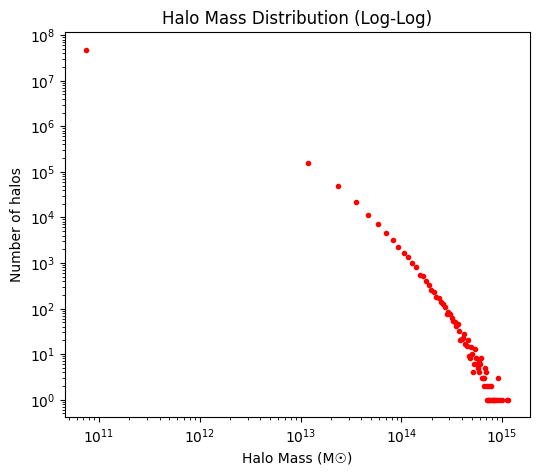

In [4]:
counts, bins = np.histogram(Mhalos_filtered, bins=100)

plt.figure(figsize=(6, 5))
plt.loglog(bins[:-1], counts, marker='o', linestyle='none', markersize=3, color='red')  # bins[:-1] car histogram renvoie un bin de plus

plt.xlabel("Halo Mass (M☉)")
plt.ylabel("Number of halos")
plt.title("Halo Mass Distribution (Log-Log)")
plt.show()

In [5]:
print(hcat.halos.columns)

<TableColumns names=('id','x_L2com','v_L2com','SO_central_density','SO_L2max_central_density','SO_radius','SO_L2max_radius','meanSpeed_L2com','meanSpeed_com','sigmav3d_L2com','sigmav3d_com','vcirc_max_L2com','vcirc_max_com','x_com','r100_L2com','r50_L2com','r25_L2com','SO_L2max_central_particle','SO_central_particle','r98_L2com','N')>


## Delete halos of non coherent mass

In [6]:
halo_radius = np.array(hcat_filtered['SO_radius'])
correlation = np.corrcoef(Mhalos_filtered, halo_radius)[0, 1]
print("correlation Mass-Radius :", correlation)

correlation Mass-Radius : 0.017223073072367243


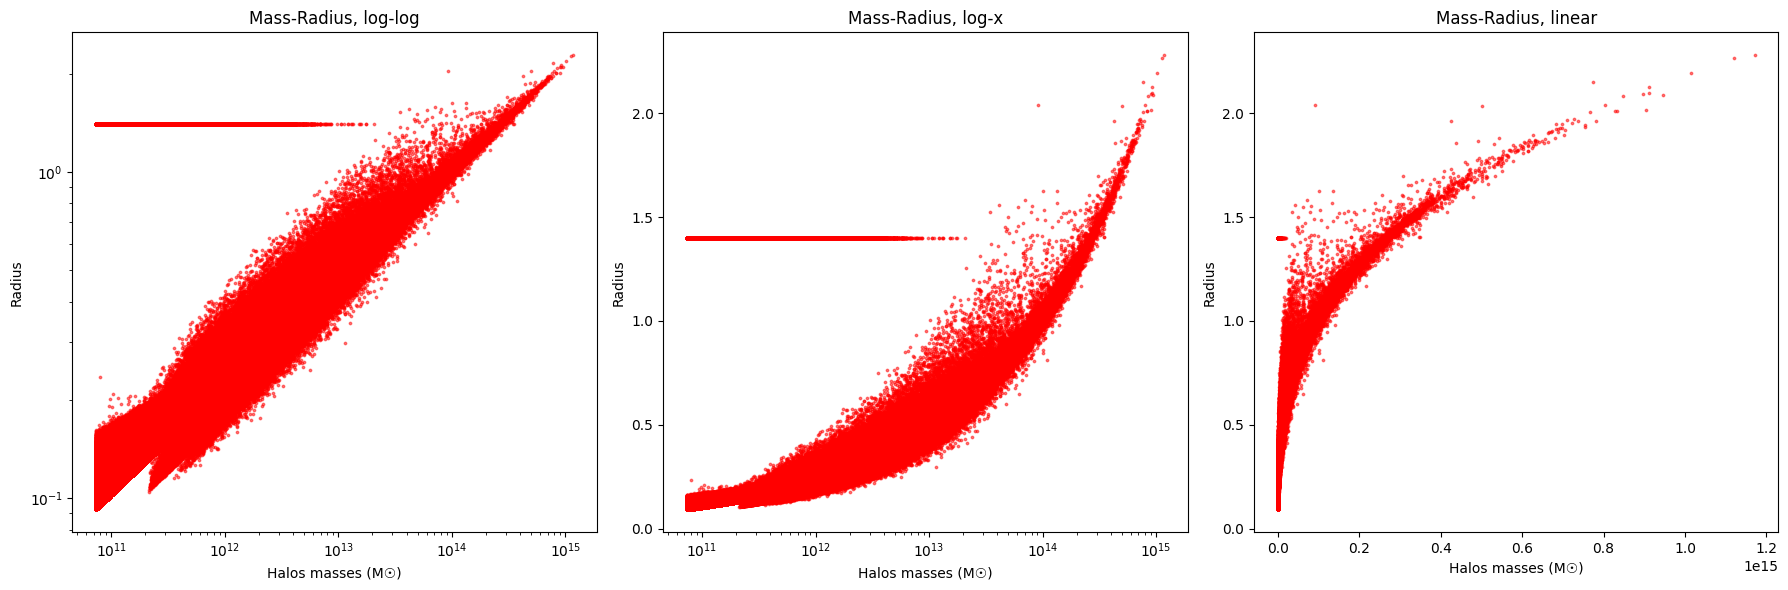

In [7]:
# Paramètres communs pour les graphes
scatter_args = {'alpha': 0.5, 's': 3, 'c': 'red'}

# 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Log-log plot
axes[0].scatter(Mhalos_filtered, halo_radius, **scatter_args)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("Mass-Radius, log-log")

# Log-x plot
axes[1].scatter(Mhalos_filtered, halo_radius, **scatter_args)
axes[1].set_xscale('log')
axes[1].set_title("Mass-Radius, log-x")

# Linear plot
axes[2].scatter(Mhalos_filtered, halo_radius, **scatter_args)
axes[2].set_title("Mass-Radius, linear")

# Ajout des labels communs
for ax in axes:
    ax.set_xlabel("Halos masses (M☉)")
    ax.set_ylabel("Radius")

plt.tight_layout()
plt.show()

The most frequent value of SO_radius is : 1.39963698387146 with 11111730 occurrences.
Note: this value appears in more than 10% of cases.


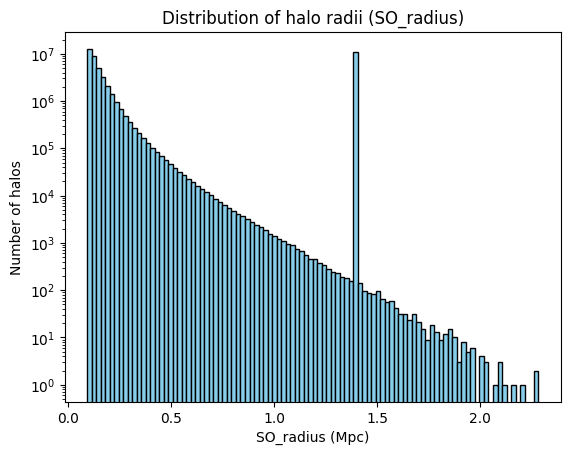

In [8]:
size_counts = Counter(halo_radius)
most_common_size, most_common_count = size_counts.most_common(1)[0]

# Check if there is a dominant value
print(f"The most frequent value of SO_radius is : {most_common_size} with {most_common_count} occurrences.")
if most_common_count > 0.1 * len(halo_radius):
    print("Note: this value appears in more than 10% of cases.")

# Histogram of SO_radius values
plt.hist(halo_radius, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("SO_radius (Mpc)")
plt.ylabel("Number of halos")
plt.title("Distribution of halo radii (SO_radius)")
plt.yscale('log')  
plt.show()

In [9]:
halo_radi98 = np.array(hcat_filtered['r98_L2com'])

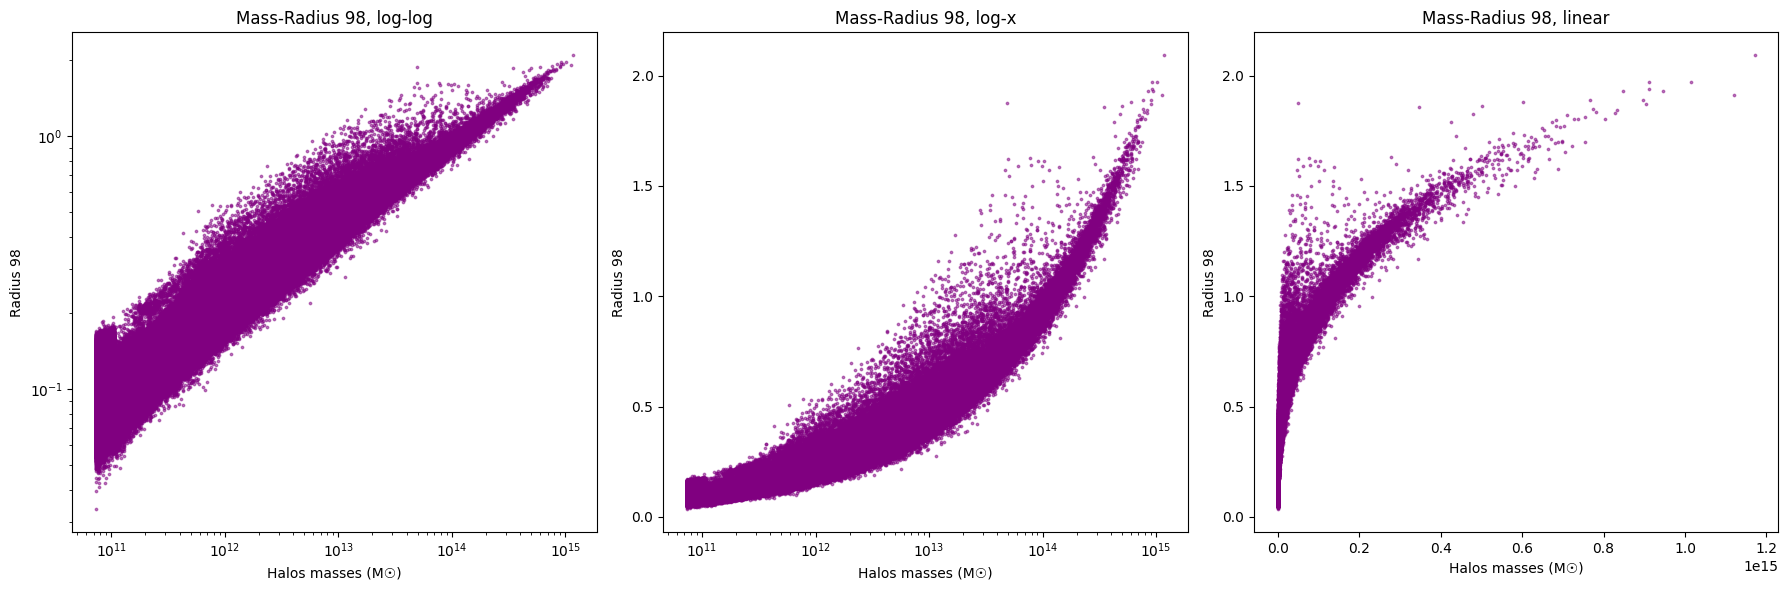

In [10]:
# Paramètres communs pour les graphes
scatter_args = {'alpha': 0.5, 's': 3, 'c': 'purple'}

# 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Log-log plot
axes[0].scatter(Mhalos_filtered, halo_radi98, **scatter_args)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("Mass-Radius 98, log-log")

# Log-x plot
axes[1].scatter(Mhalos_filtered, halo_radi98, **scatter_args)
axes[1].set_xscale('log')
axes[1].set_title("Mass-Radius 98, log-x")

# Linear plot
axes[2].scatter(Mhalos_filtered, halo_radi98, **scatter_args)
axes[2].set_title("Mass-Radius 98, linear")

# Ajout des labels communs
for ax in axes:
    ax.set_xlabel("Halos masses (M☉)")
    ax.set_ylabel("Radius 98")

plt.tight_layout()
plt.show()

In [11]:
# # Définir une limite de masse pour exclure uniquement les petits halos avec la taille la plus fréquente
# mass_threshold = 2*10**13  

# # Filtrer les halos : garder ceux qui n'ont pas most_common_size ou qui ont une masse supérieure à la limite
# #filtered_indices = (halo_radius != most_common_size) | (Mhalos > mass_threshold)

# # Filtrer les halos : enlever ceux qui sont à most_common_size ET qui ont une masse supérieure à la limite
# filtered_indices = ~((halo_radius == most_common_size) & (Mhalos_filtered < mass_threshold))

# # Appliquer le filtre aux données
# filtered_Mhalos = Mhalos_filtered[filtered_indices]
# filtered_halos = hcat_filtered[filtered_indices]

# halo_radius = filtered_halos['SO_radius']

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # Premier graphique : Scatter plot Mass-Radius, log-log
# axes[0].scatter(filtered_Mhalos, halo_radius, alpha=0.5, s=3, c='red')
# axes[0].set_xscale('log')
# axes[0].set_yscale('log')
# axes[0].set_xlabel("Halos masses (M☉)")
# axes[0].set_ylabel("Radius")
# axes[0].set_title("New Mass-Radius correlation, log-log")

# # Deuxième graphique : Histogramme de SO_radius
# axes[1].hist(halo_radius, bins=100, color='skyblue', edgecolor='black')
# axes[1].set_xlabel("SO_radius (Mpc)")
# axes[1].set_ylabel("Number of halos")
# axes[1].set_title("Distribution of halo radii (SO_radius)")
# axes[1].set_yscale('log')

# plt.tight_layout()
# plt.show()

## Selection of 10% of the sample

In [12]:
# The goal is to work with 10% of the halos to lighten the computation
# We want them to keep the original repartition of mass

num_bins = 10  # 10 mass categories
mass_bins_cat = pd.qcut(Mhalos_filtered, num_bins, labels=False) # Cut the sample in 10 categories

print(mass_bins_cat) # Each halo is in a mass category btw 0 and 9
print(f"Number of halos : {len(Mhalos_filtered):,}")

sampled_indices_cat = []

for category in range(num_bins):
    indices_in_category = np.where(mass_bins_cat == category)[0] # indices of halos in the category
    category_size = len(indices_in_category)
    size = int(0.1 * category_size) 

    print(f"Catégorie {category}: {category_size} halos, échantillon de taille {size}")
    
    sampled_in_category = np.random.choice(
        indices_in_category, 
        size=size, 
        replace=False
    ) # Randomly choose 10% of the halo in the given category

    sampled_indices_cat.extend(sampled_in_category)

sampled_halos_cat = hcat_filtered[sampled_indices_cat]
sampled_masses_cat = Mhalos_filtered[sampled_indices_cat] 
print(f"Number of sampled halos : {len(sampled_halos_cat):,}")

sampled_indices_cat = [int(index) for index in sampled_indices_cat]

print("Indices des halos échantillonnés :", sampled_indices_cat[:10])  # 10 first indices
print("Masses des halos échantillonnés :", sampled_masses_cat[:10]) 

[9 4 6 ... 1 9 0]
Number of halos : 48,359,672
Catégorie 0: 5441884 halos, échantillon de taille 544188
Catégorie 1: 4491498 halos, échantillon de taille 449149
Catégorie 2: 4967304 halos, échantillon de taille 496730
Catégorie 3: 4717192 halos, échantillon de taille 471719
Catégorie 4: 4590602 halos, échantillon de taille 459060
Catégorie 5: 5004792 halos, échantillon de taille 500479
Catégorie 6: 4699790 halos, échantillon de taille 469979
Catégorie 7: 4774943 halos, échantillon de taille 477494
Catégorie 8: 4837391 halos, échantillon de taille 483739
Catégorie 9: 4834276 halos, échantillon de taille 483427
Number of sampled halos : 4,835,964
Indices des halos échantillonnés : [41783699, 2686264, 46490211, 22507026, 13778250, 38958701, 980675, 3132588, 17645978, 33924558]
Masses des halos échantillonnés :         N        
-----------------
73817853215.85721
 80145097777.2164
 80145097777.2164
75926934736.31027
 80145097777.2164
73817853215.85721
75926934736.31027
73817853215.85721
7

In [13]:
data = {
    'id': hcat_filtered['id'], 
    'mass': Mhalos_filtered,
}

df = pd.DataFrame(data)

# Étape 1 : Attribuer un numéro aléatoire entre 1 et 10 à chaque halo
df['random_group'] = np.random.randint(1, 11, size=len(df))  # Numéros entre 1 et 10

# Étape 2 : Choisir un pourcentage d'échantillonnage (exemple : 10% des halos)
sample_size = int(0.1 * len(df))  # 10% de l'échantillon total

# Étape 4 : Extraire les halos des groupes choisis
sampled_halos = df[df['random_group']==3]

# Afficher l'échantillon obtenu
print(f"Sample of {len(sampled_halos):,} halos.")
print(sampled_halos.head())

sampled_indices = sampled_halos.index.tolist()
sampled_masses = Mhalos_filtered[sampled_indices]
sampled_halos = hcat_filtered[sampled_indices]

Sample of 4,836,868 halos.
           id          mass  random_group
10   52000000  1.265449e+11             3
15  132000000  1.117813e+11             3
21  159000000  8.436326e+10             3
23  231000000  8.647234e+10             3
35  378002001  1.054541e+11             3


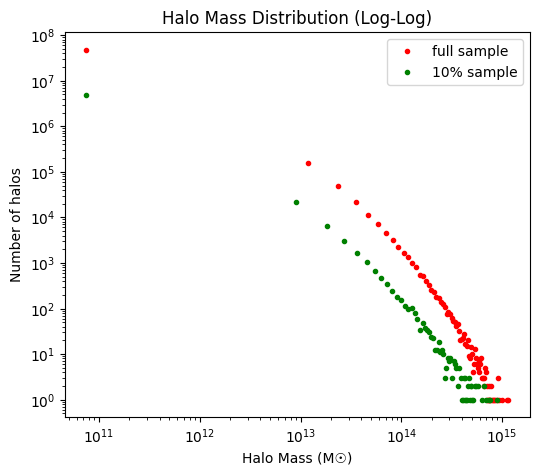

In [14]:
#counts_new, bins_new = np.histogram(sampled_masses_cat, bins=100)
counts_strat, bins_strat = np.histogram(sampled_masses, bins=100)

plt.figure(figsize=(6, 5))
plt.loglog(bins[:-1], counts, marker='o', linestyle='none', markersize=3, color='red', label='full sample')
#plt.loglog(bins_new[:-1], counts_new, marker='o', linestyle='none', markersize=3, color='black', label='10% sample')  # bins[:-1] car histogram renvoie un bin de plus
plt.loglog(bins_strat[:-1], counts_strat, marker='o', linestyle='none', markersize=3, color='green', label='10% sample')

plt.xlabel("Halo Mass (M☉)")
plt.ylabel("Number of halos")
plt.title("Halo Mass Distribution (Log-Log)")
plt.legend()
plt.show()

## Mass-velocity correlation

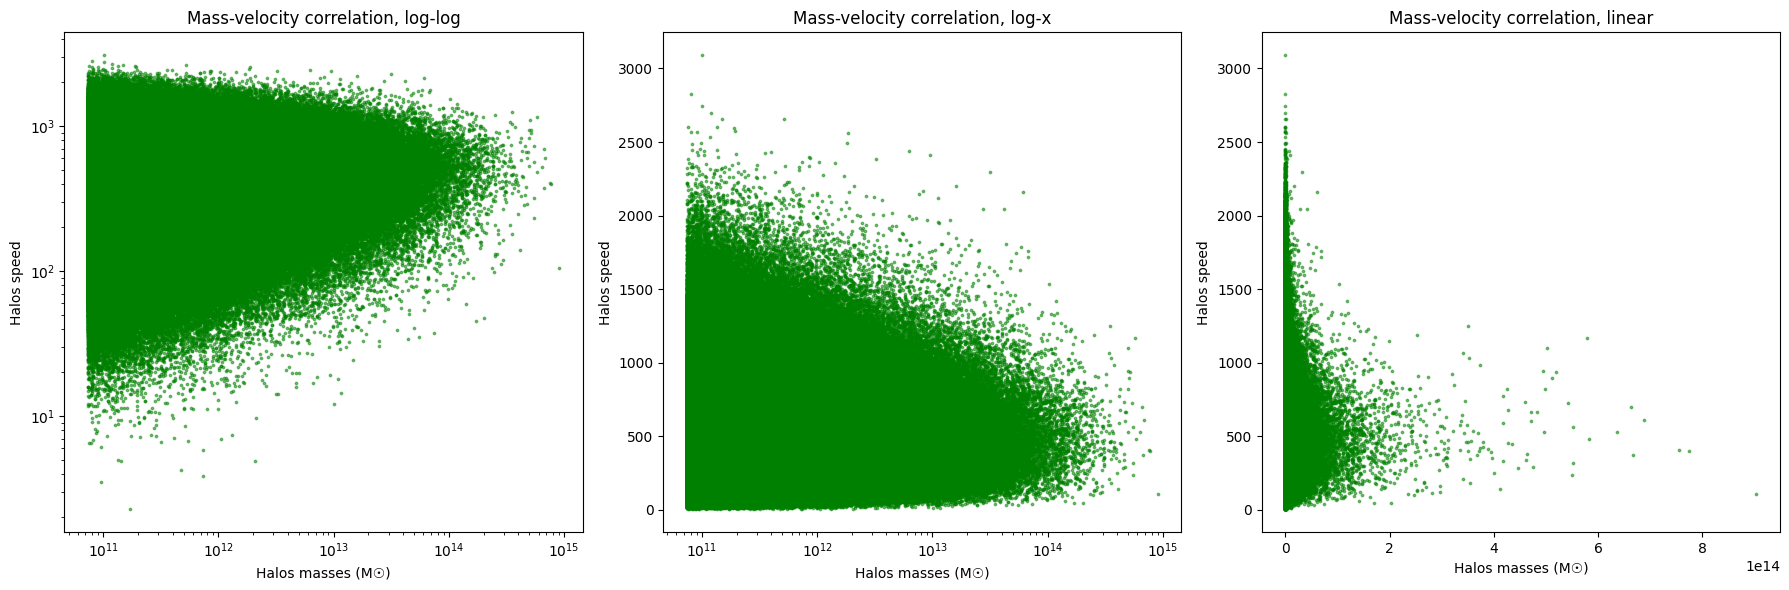

In [15]:
velocities = np.linalg.norm(sampled_halos['v_L2com'], axis=1) 

# 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Log-log
axes[0].scatter(sampled_masses, velocities, alpha=0.5, s=3, c='green')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel("Halos masses (M☉)")
axes[0].set_ylabel("Halos speed")
axes[0].set_title("Mass-velocity correlation, log-log")

# Log-x
axes[1].scatter(sampled_masses, velocities, alpha=0.5, s=3, c='green')
axes[1].set_xscale('log')
axes[1].set_xlabel("Halos masses (M☉)")
axes[1].set_ylabel("Halos speed")
axes[1].set_title("Mass-velocity correlation, log-x")

# Linear
axes[2].scatter(sampled_masses, velocities, alpha=0.5, s=3, c='green')
axes[2].set_xlabel("Halos masses (M☉)")
axes[2].set_ylabel("Halos speed")
axes[2].set_title("Mass-velocity correlation, linear")

plt.tight_layout()
plt.show()

## Correlation Mass - Distance to nearest neighbour

In [16]:
# Coord and halos masses 
positions = np.array(sampled_halos['x_L2com'])  
halo_sizes = np.array(sampled_halos['r98_L2com'])

# Build a KD tree to find the nearest neighbours efficiently
kdtree = KDTree(positions)

# Calculate the nearest neighbour distance for each halo
distances_to_nearest = []
for pos in positions:
    distance, index = kdtree.query(pos, k=2)  # k=2 because the first neighbour is the halo itself
    distances_to_nearest.append(distance[1])  # Take the distance to the second nearest neighbour (other than yourself)

distances_to_nearest = np.array(distances_to_nearest)

# Calculate the correlation between mass and distance to nearest neighbour
correlation = np.corrcoef(sampled_masses, distances_to_nearest)[0, 1]
print("correlation Mass-Distance to nearest neighbour :", correlation)

correlation Mass-Distance to nearest neighbour : -0.053831551162953524


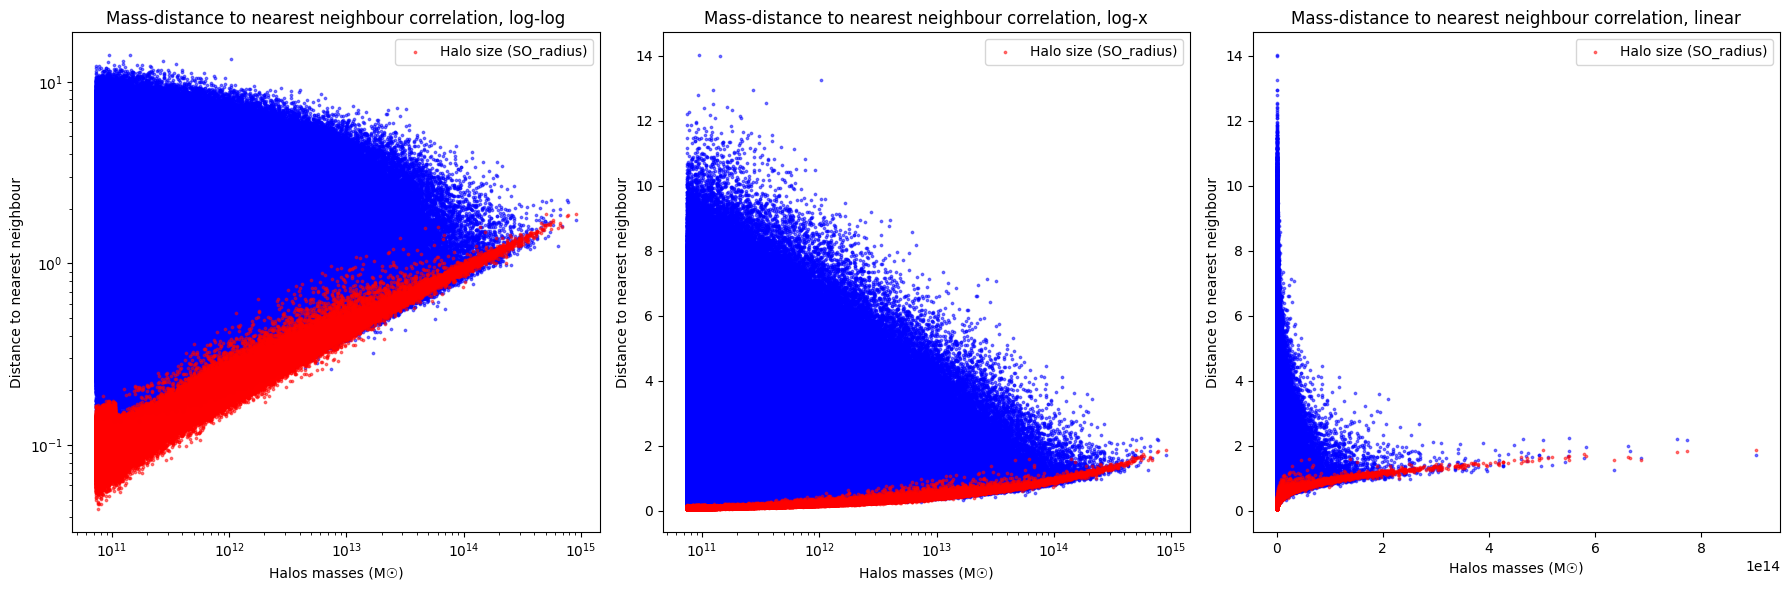

In [17]:
# 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Log-log
axes[0].scatter(sampled_masses, distances_to_nearest, alpha=0.5, s=3, c='blue')
axes[0].scatter(sampled_masses, halo_sizes, alpha=0.5, s=3, c='red', label="Halo size (SO_radius)")
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel("Halos masses (M☉)")
axes[0].set_ylabel("Distance to nearest neighbour")
axes[0].set_title("Mass-distance to nearest neighbour correlation, log-log")
axes[0].legend(loc="upper right")

# Log-x
axes[1].scatter(sampled_masses, distances_to_nearest, alpha=0.5, s=3, c='blue')
axes[1].scatter(sampled_masses, halo_sizes, alpha=0.5, s=3, c='red', label="Halo size (SO_radius)")
axes[1].set_xscale('log')
axes[1].set_xlabel("Halos masses (M☉)")
axes[1].set_ylabel("Distance to nearest neighbour")
axes[1].set_title("Mass-distance to nearest neighbour correlation, log-x")
axes[1].legend(loc="upper right")

# Linear
axes[2].scatter(sampled_masses, distances_to_nearest, alpha=0.5, s=3, c='blue')
axes[2].scatter(sampled_masses, halo_sizes, alpha=0.5, s=3, c='red', label="Halo size (SO_radius)")
axes[2].set_xlabel("Halos masses (M☉)")
axes[2].set_ylabel("Distance to nearest neighbour")
axes[2].set_title("Mass-distance to nearest neighbour correlation, linear")
axes[2].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Correlation Mass - Central Halo Density

Corrélation entre la Masse et la Densité Centrale : 0.7317026144559445


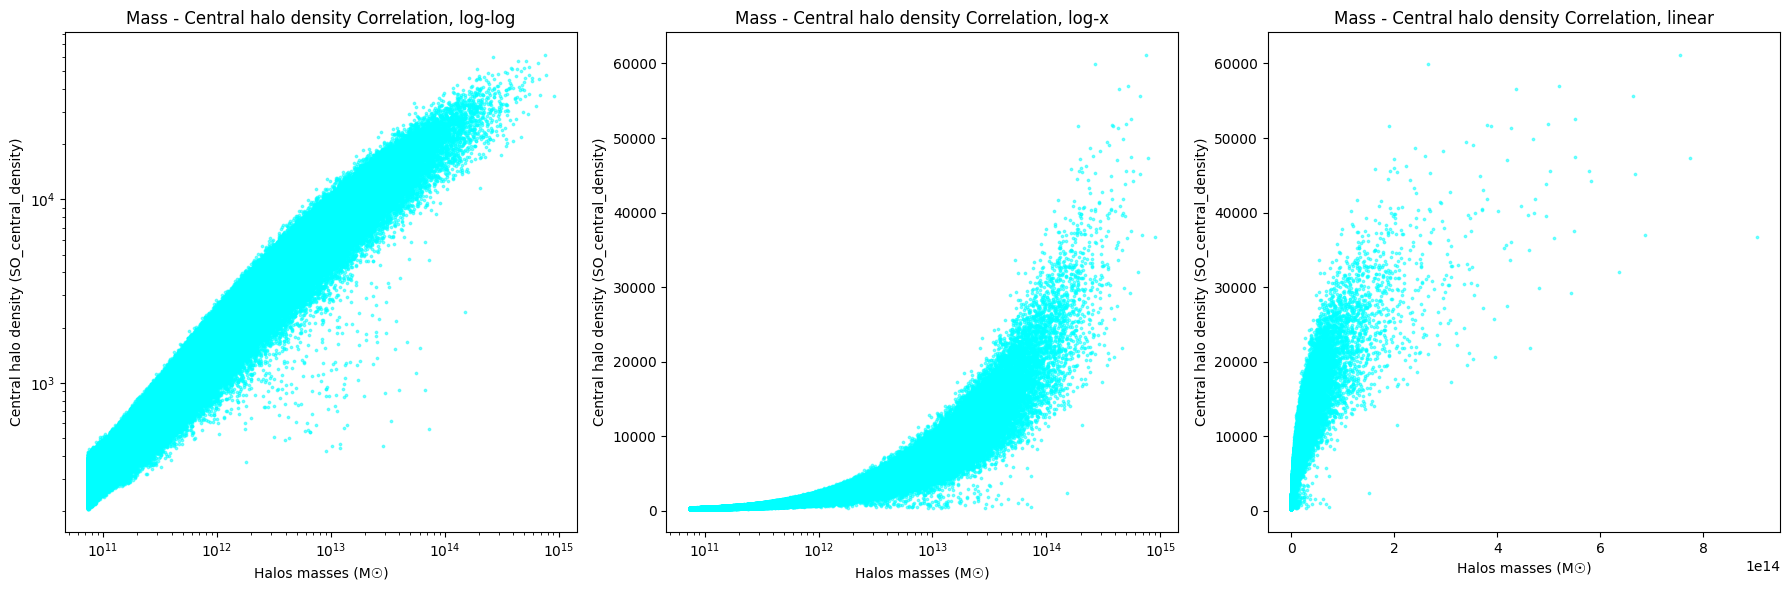

In [18]:
central_density = np.array(sampled_halos['SO_central_density'])  # Densité centrale de chaque halo

# Calculer la corrélation entre la masse et la densité centrale
correlation = np.corrcoef(sampled_masses, central_density)[0, 1]
print("Corrélation entre la Masse et la Densité Centrale :", correlation)

# 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Log-log
axes[0].scatter(sampled_masses, central_density, alpha=0.5, s=3, c='cyan')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel("Halos masses (M☉)")
axes[0].set_ylabel("Central halo density (SO_central_density)")
axes[0].set_title("Mass - Central halo density Correlation, log-log")

# Log-x
axes[1].scatter(sampled_masses, central_density, alpha=0.5, s=3, c='cyan')
axes[1].set_xscale('log')
axes[1].set_xlabel("Halos masses (M☉)")
axes[1].set_ylabel("Central halo density (SO_central_density)")
axes[1].set_title("Mass - Central halo density Correlation, log-x")

# Linear
axes[2].scatter(sampled_masses, central_density, alpha=0.5, s=3, c='cyan')
axes[2].set_xlabel("Halos masses (M☉)")
axes[2].set_ylabel("Central halo density (SO_central_density)")
axes[2].set_title("Mass - Central halo density Correlation, linear")

plt.tight_layout()
plt.show()

## Correlation Central Density - Maximum Circular Speed

Correlation between Central Density and Maximum Circular Speed : 0.9495253758660447


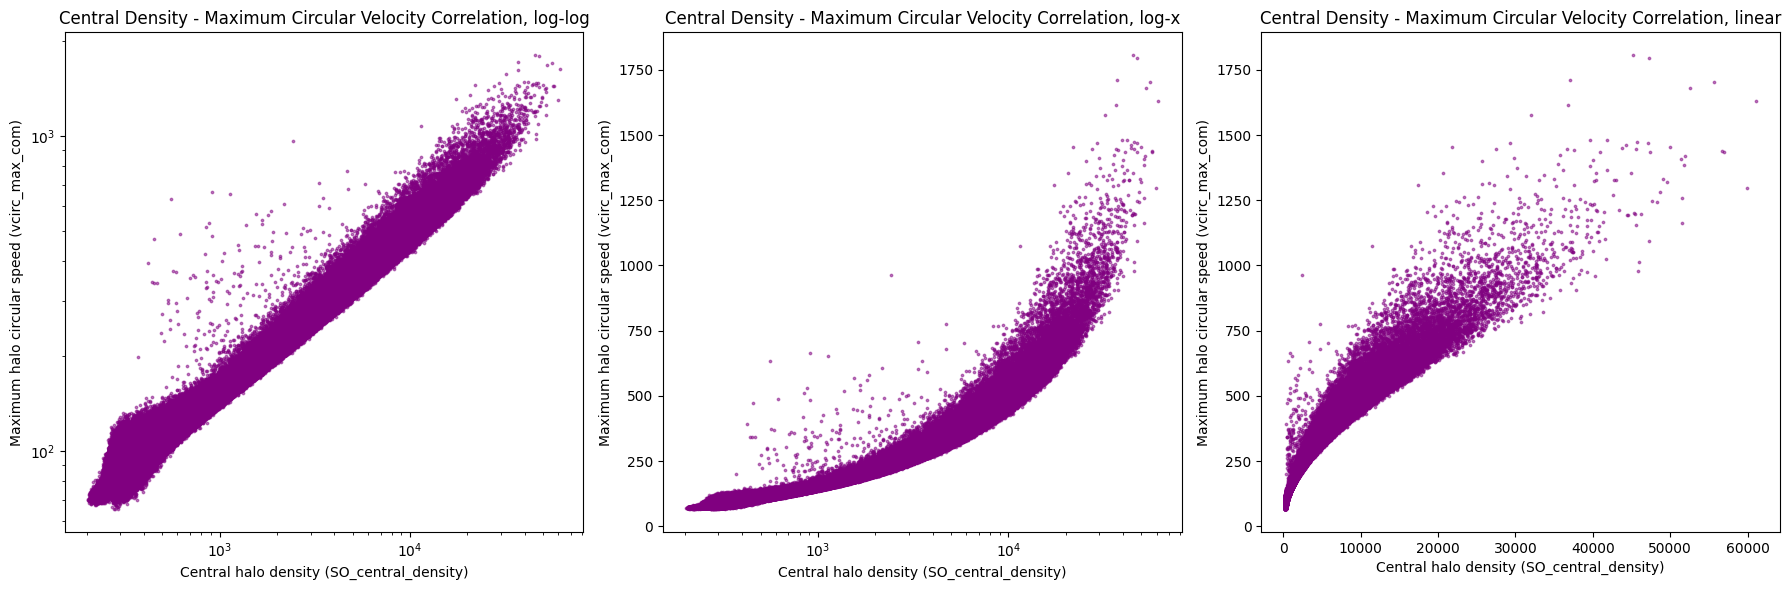

In [19]:
vcirc_max = np.array(sampled_halos['vcirc_max_com'])  # Circular speed

correlation = np.corrcoef(central_density, vcirc_max)[0, 1]
print("Correlation between Central Density and Maximum Circular Speed :", correlation)

# 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Log-log
axes[0].scatter(central_density, vcirc_max, alpha=0.5, s=3, c='purple')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel("Central halo density (SO_central_density)")
axes[0].set_ylabel("Maximum halo circular speed (vcirc_max_com)")
axes[0].set_title("Central Density - Maximum Circular Velocity Correlation, log-log")

# Log-x
axes[1].scatter(central_density, vcirc_max, alpha=0.5, s=3, c='purple')
axes[1].set_xscale('log')
axes[1].set_xlabel("Central halo density (SO_central_density)")
axes[1].set_ylabel("Maximum halo circular speed (vcirc_max_com)")
axes[1].set_title("Central Density - Maximum Circular Velocity Correlation, log-x")

# Linear
axes[2].scatter(central_density, vcirc_max, alpha=0.5, s=3, c='purple')
axes[2].set_xlabel("Central halo density (SO_central_density)")
axes[2].set_ylabel("Maximum halo circular speed (vcirc_max_com)")
axes[2].set_title("Central Density - Maximum Circular Velocity Correlation, linear")

plt.tight_layout()
plt.show()

## Circular speed vs mass

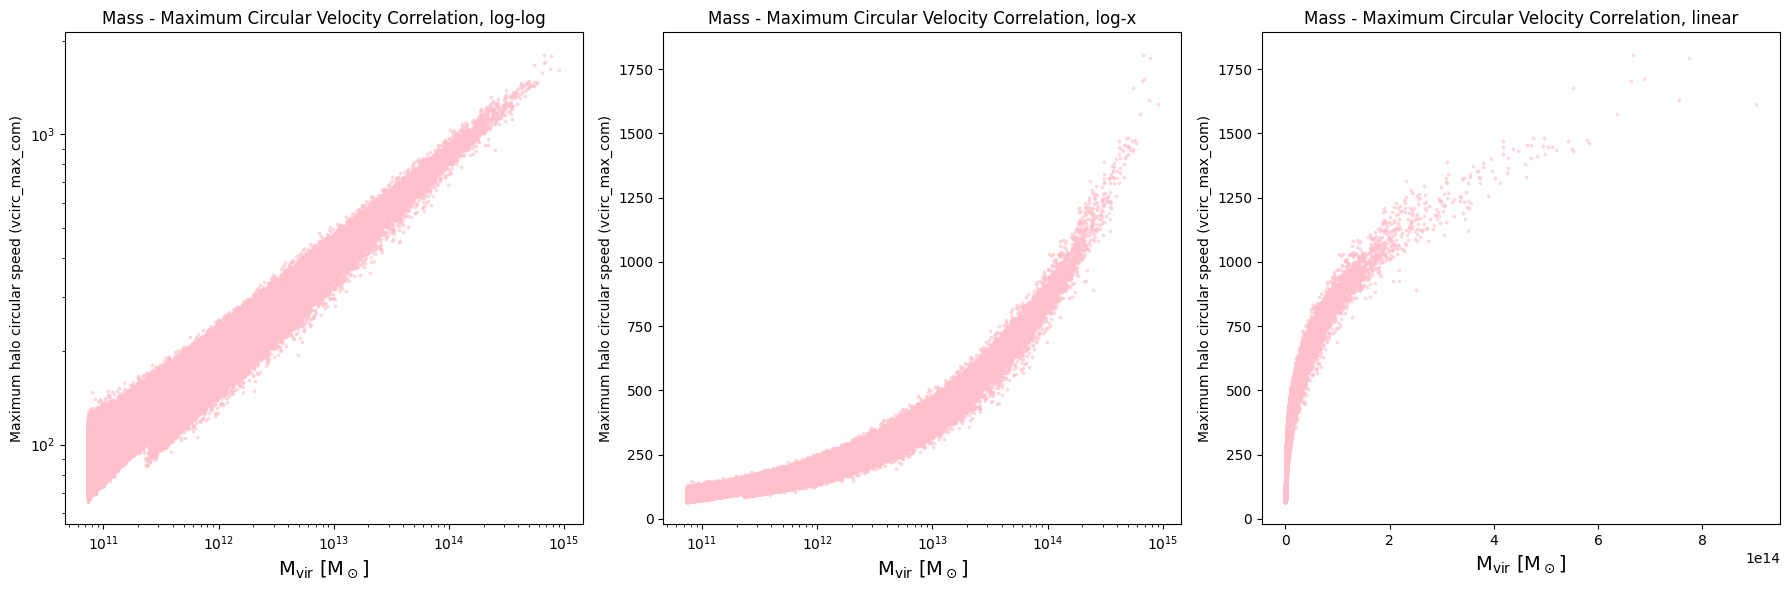

In [20]:
# 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Log-log
axes[0].scatter(sampled_masses, vcirc_max, alpha=0.5, s=3, c='pink')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r"M$_{\text{vir}}$ [M$_\odot$]", fontsize=14)
axes[0].set_ylabel("Maximum halo circular speed (vcirc_max_com)")
axes[0].set_title("Mass - Maximum Circular Velocity Correlation, log-log")

# Log-x
axes[1].scatter(sampled_masses, vcirc_max, alpha=0.5, s=3, c='pink')
axes[1].set_xscale('log')
axes[1].set_xlabel(r"M$_{\text{vir}}$ [M$_\odot$]", fontsize=14)
axes[1].set_ylabel("Maximum halo circular speed (vcirc_max_com)")
axes[1].set_title("Mass - Maximum Circular Velocity Correlation, log-x")

# Linear
axes[2].scatter(sampled_masses, vcirc_max, alpha=0.5, s=3, c='pink')
axes[2].set_xlabel(r"M$_{\text{vir}}$ [M$_\odot$]", fontsize=14)
axes[2].set_ylabel("Maximum halo circular speed (vcirc_max_com)")
axes[2].set_title("Mass - Maximum Circular Velocity Correlation, linear")

plt.tight_layout()
plt.show()

In [21]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(np.log10(vcirc_max), np.log10(sampled_masses))
print(f"Pente : {slope:.2f}, Intercept : {intercept:.2f}, R² : {r_value**2:.2f}")

# Tully-Fisher relationship : M α v_circ, max^3

Pente : 2.87, Intercept : 5.40, R² : 0.95


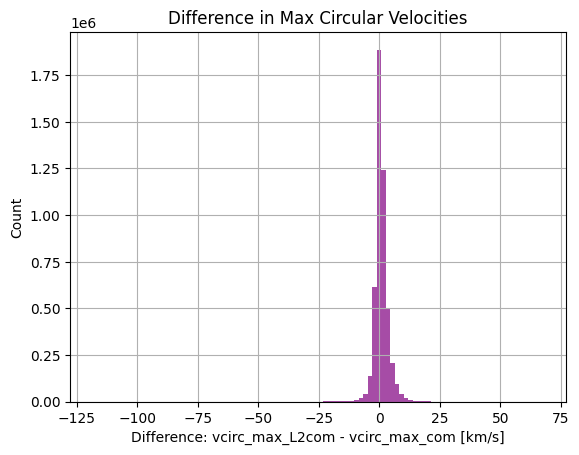

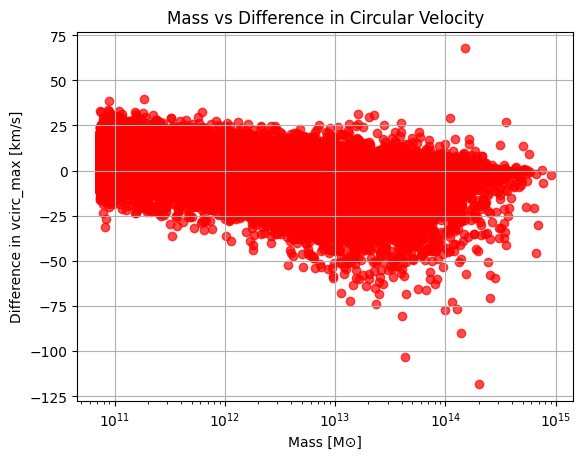

In [22]:
vcirc_max_L2 = np.array(sampled_halos['vcirc_max_L2com'])

vcirc_diff = vcirc_max_L2 - vcirc_max
plt.hist(vcirc_diff, bins=100, color='purple', alpha=0.7)
plt.xlabel("Difference: vcirc_max_L2com - vcirc_max_com [km/s]")
plt.ylabel("Count")
plt.title("Difference in Max Circular Velocities")
plt.grid(True)
plt.show()

plt.scatter(sampled_masses, vcirc_diff, alpha=0.7, c='red')
plt.xscale('log')
plt.xlabel("Mass [M⊙]")
plt.ylabel("Difference in vcirc_max [km/s]")
plt.title("Mass vs Difference in Circular Velocity")
plt.grid(True)
plt.show()

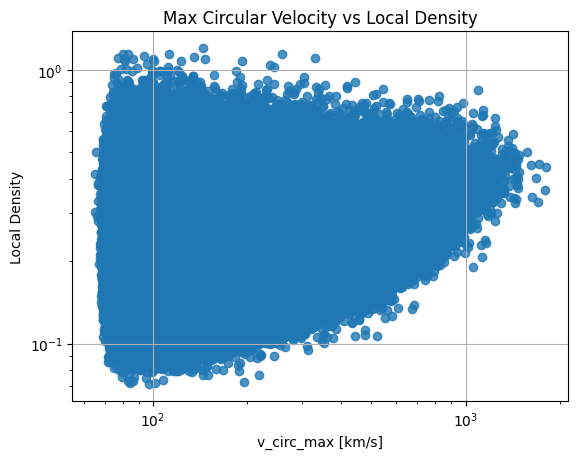

In [23]:
tree = cKDTree(positions)
local_densities = []
for pos in positions:
    distances, _ = tree.query(pos, k=10)
    local_density = 1 / distances.mean()
    local_densities.append(local_density)

# Tracé de v_circ_max vs densité locale
plt.scatter(vcirc_max, local_densities, alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("v_circ_max [km/s]")
plt.ylabel("Local Density")
plt.title("Max Circular Velocity vs Local Density")
plt.grid(True)
plt.show()

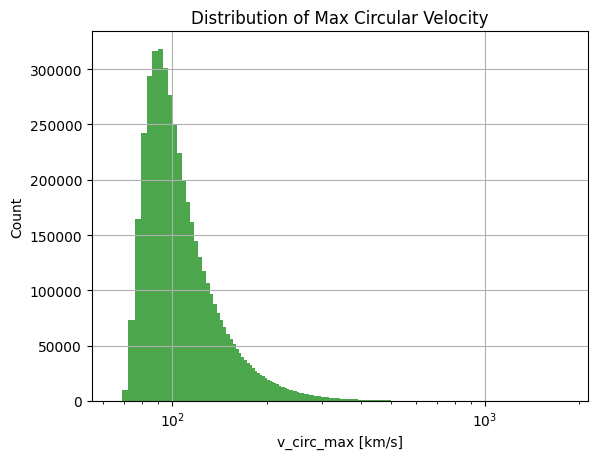

In [24]:
plt.hist(vcirc_max, bins=500, color='green', alpha=0.7)
plt.xscale('log')
plt.xlabel("v_circ_max [km/s]")
plt.ylabel("Count")
plt.title("Distribution of Max Circular Velocity")
plt.grid(True)
plt.show()

# Dominance des halos de faible rayons donc de faible masse

0.315192


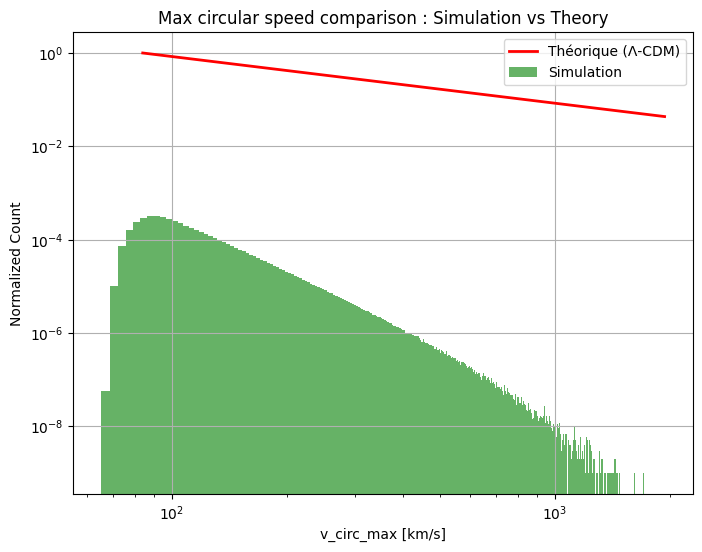

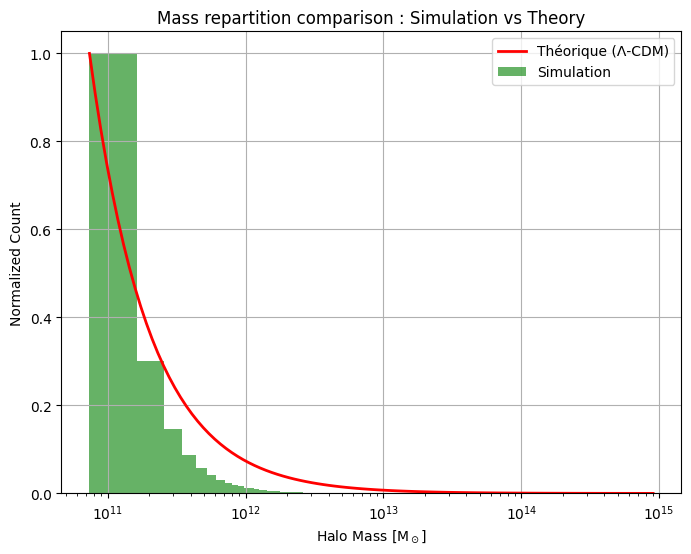

In [25]:
def sheth_tormen_mass_function(sigma):
    A = 0.3222
    p = 0.3
    a = 0.707
    delta_c=1.686

    nu = delta_c / sigma
    return A * np.sqrt(2 / np.pi) * nu * (1 + (1 / a*nu**2)**p) * np.exp(-a*nu**2 / 2)

# cosmological parameters
Omega_m = hcat.header['Omega_M'] # total density of matter
print(Omega_m)
sigma_8 = 0.8 

# Volume of the simulation
boxsizeHMpc = hcat.header['BoxSizeHMpc']
volume_sim = boxsizeHMpc **3 

pho_m = 2.775e11 * Omega_m  # Densité moyenne de matière (en M☉/h^-3)

M_min = np.min(sampled_masses)
M_max = np.max(sampled_masses)
M = np.logspace(np.log10(M_min), np.log10(M_max), 100)  # Masses en M☉/h

n_M = sheth_tormen_mass_function(sigma_8) * pho_m / M
n_M_normalized = n_M * volume_sim

v_circ_theo = (M / 1e12)**(1/3) * 200 
n_v_circ = n_M_normalized * (3 * v_circ_theo**2)

hist_sim, bins = np.histogram(vcirc_max, bins=500)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
hist_sim_density = hist_sim / volume_sim

# Normalisation de la courbe théorique
n_v_circ_density = n_v_circ / volume_sim
n_v_circ_normalized = n_v_circ_density / np.max(n_v_circ_density)

plt.figure(figsize=(8, 6))
plt.plot(v_circ_theo, n_v_circ_normalized, label="Théorique (\u039B-CDM)", color="red", lw=2)
plt.bar(bin_centers, hist_sim_density, width=np.diff(bins), alpha=0.6, label="Simulation", color="green")
plt.xlabel("v_circ_max [km/s]")
plt.ylabel("Normalized Count")
plt.xscale('log')
plt.yscale('log')
plt.title("Max circular speed comparison : Simulation vs Theory")
plt.legend()
plt.grid(True)
plt.show()

hist_sim_counts, bins = np.histogram(sampled_masses, bins=10000)  # Histogramme brut
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Centres des bins
hist_sim_density = hist_sim_counts / volume_sim  # Normalisation par le volume

# Normalisation de la courbe théorique
n_M_density = n_M / volume_sim
n_M_normalized = n_M_density / np.max(n_M_density)

# Tracé
plt.figure(figsize=(8, 6))

# Courbe théorique
plt.plot(M, n_M_normalized, label="Théorique (\u039B-CDM)", color="red", lw=2)

# Histogramme simulé
plt.bar(bin_centers, hist_sim_density / np.max(hist_sim_density), width=np.diff(bins),
        alpha=0.6, label="Simulation", color="green")

# Échelles et labels
plt.xlabel(r"Halo Mass [M$_\odot$]")
plt.ylabel("Normalized Count")
plt.xscale("log")
plt.title("Mass repartition comparison : Simulation vs Theory")
plt.legend()
plt.grid(True)
plt.show()

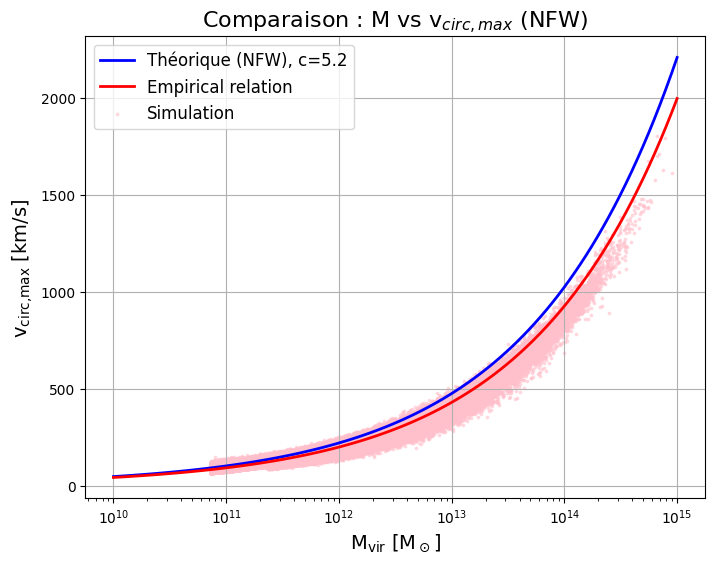

In [26]:
H0 = hcat.header['H0']
h = H0 / 100

G = 4.301e-9  # Constante gravitationnelle en Mpc^3 / Msol / s^2
rho_crit = 2.775e11 * h**2  # Densité critique en Msol / Mpc^3
Delta_c = 200  # Facteur de surdensité
c = 5.2  # Paramètre de concentration typique

# Masse de virial en unités de Msol
Mvir = np.logspace(10, 15, 100)  # Plage de masses de 10^10 à 10^15 Msol

# Calcul du rayon de virial
r_vir = (3 * Mvir / (4 * np.pi * Delta_c * rho_crit))**(1/3)  # en Mpc

# Calcul du rayon d'échelle
r_s = r_vir / c

# Calcul de la densité caractéristique
rho_0 = (Delta_c * rho_crit / 3) * (c**3 / (np.log(1 + c) - c / (1 + c)))

# Calcul de la masse à r_max
r_max = 2.16 * r_s  # Rayon où v_circ est max
M_r_max = 4 * np.pi * rho_0 * r_s**3 * (np.log(1 + r_max/r_s) - (r_max/r_s) / (1 + r_max/r_s))

# Calcul de v_circ_max
v_circ_max_nfw = np.sqrt(G * Mvir / r_max)  # en km/s

# (km/s) Empirical relation
v_circ_max_theo = (Mvir / 1e12)**(1/3) * 200  

# Tracé
plt.figure(figsize=(8, 6))
plt.plot(Mvir, v_circ_max_nfw, label=f"Théorique (NFW), c={c}", color="blue", lw=2)
plt.plot(Mvir, v_circ_max_theo, label="Empirical relation", color="red", lw=2)

# Exemple de données simulées
plt.scatter(sampled_masses, vcirc_max, alpha=0.5, s=3, c='pink', label="Simulation")

# Paramètres des axes
plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"M$_{\text{vir}}$ [M$_\odot$]", fontsize=14)
plt.ylabel(r"v$_{\text{circ,max}}$ [km/s]", fontsize=14)
plt.title("Comparaison : M vs v$_{\t{circ,max}}$ (NFW)", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12, loc='upper left')
plt.show()

## 2PCF

In [27]:
positions = np.array(sampled_halos['x_L2com'])
positions = positions.astype(np.float64)
print("Shape of positions:", positions.shape)
x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
print(x,y,z)



Shape of positions: (4836868, 3)
[-499.49346924 -499.70275879 -499.52978516 ...  498.99822998  499.96505737
  499.10070801] [-499.51290894 -498.85256958 -498.93826294 ...  499.44732666  499.33847046
  499.66027832] [-435.927948   -339.78118896 -306.91818237 ...  208.06292725  294.8135376
  425.44726562]


### SMU

Simulation Box Size : 1000.0
Shape of s : (50, 50)
Shape of xi(s) : (50, 50)
Shape of sepmid : (50,)
Shape of sepavg : (50,)


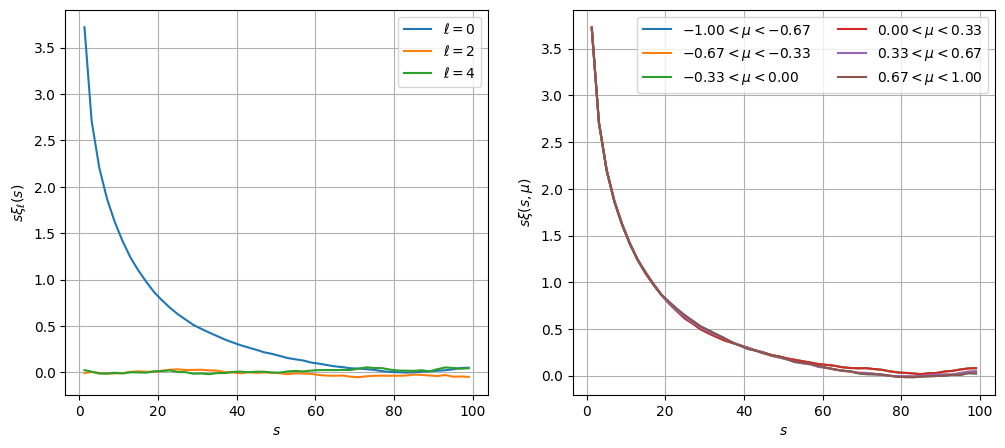

In [28]:
boxsize = hcat.header['BoxSize']
print("Simulation Box Size :", boxsize)

bins_s = np.linspace(0, 100, 51)  # Intervalles des distances en Mpc/h
bins_mu = np.linspace(-1, 1, 51)    # Intervalles des cosinus d'angle

# 2PCF Calculations
results = TwoPointCorrelationFunction(
    mode='smu',  
    edges=(bins_s, bins_mu),  # Bornes des distances pour les bins
    data_positions1=(x, y, z),  # Positions des halos
    boxsize=boxsize,  # Taille de la boîte pour corriger les effets de bord
    los='z',
    nthreads=16
)

# Results
xi = results.corr  # Values of 2PCF
bin_centers = results.sep  # Corresponding distances

print('Shape of s :', bin_centers.shape)  # Should be dimension (n,)
print(f'Shape of xi(s) : {xi.shape}')

# mid (center of bins) separations can be obtained through
sepmid = results.sepavg(axis=0, method='mid')
# pair weighted average separation can be obtained through
sepavg = results.sepavg(axis=0)

print('Shape of sepmid :', sepmid.shape)
print(f'Shape of sepavg : {sepavg.shape}')

fig, lax = plt.subplots(ncols=2, nrows=1, sharex=False, sharey=False, figsize=(12, 5))

# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
s, xiell = results(ells=ells, return_sep=True)
ax = lax[0]
for ill, ell in enumerate(ells):
    ax.plot(s, s * xiell[ill], label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$s \xi_{\ell}(s)$')

# Let us project to wedges
wedges = (-1., -2./3, -1./3, 0., 1./3, 2./3, 1.)
s, ximu = results(wedges=wedges, return_sep=True)
ax = lax[1]
for iwedge, wedge in enumerate(zip(wedges[:-1], wedges[1:])):
    ax.plot(s, s * ximu[iwedge], label=r'${:.2f} < \mu < {:.2f}$'.format(*wedge))
ax.legend(ncol=2)
ax.grid(True)
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$s \xi(s, \mu)$')
plt.show()

### RPPI

In [29]:
x, y, z = np.asarray(positions[:, 0]), np.asarray(positions[:, 1]), np.asarray(positions[:, 2])

bins_rp = np.linspace(0, 75, 76)  # (0,40,41)
bins_pi = np.linspace(-75, 75, 151)   # (-40,40,81)


# 2PCF Calculations
results_rppi = TwoPointCorrelationFunction(
    mode='rppi',  
    edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
    data_positions1=(x, y, z),  # Positions des halos
    nthreads=16,
    boxsize=boxsize,
    los='z'
)

In [30]:
# Afficher tous les attributs et méthodes de l'objet results_rppi
print(dir(results_rppi))

['D1D2', 'R1R2', 'XX', '__add__', '__call__', '__class__', '__copy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_tuple_requires', 'concatenate_x', 'copy', 'corr', 'count_names', 'deepcopy', 'edges', 'from_state', 'get_corr', 'load', 'log_critical', 'log_debug', 'log_error', 'log_info', 'log_warning', 'logger', 'mode', 'mpicomm', 'name', 'ndim', 'normalize', 'plot', 'rebin', 'requires', 'run', 'save', 'save_txt', 'select', 'sep', 'sepavg', 'seps', 'shape', 'slice', 'sum', 'with_mpi', 'with_shifted', 'wrap']


In [31]:
pi = results_rppi.sepavg(axis=1)
print(pi)

xi_rppi = results_rppi.corr
print(xi_rppi)

[-74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5 -66.5 -65.5 -64.5 -63.5
 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5
 -50.5 -49.5 -48.5 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5 -41.5 -40.5 -39.5
 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5 -29.5 -28.5 -27.5
 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5
 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5
  -2.5  -1.5  -0.5   0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5
   9.5  10.5  11.5  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5
  21.5  22.5  23.5  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5  32.5
  33.5  34.5  35.5  36.5  37.5  38.5  39.5  40.5  41.5  42.5  43.5  44.5
  45.5  46.5  47.5  48.5  49.5  50.5  51.5  52.5  53.5  54.5  55.5  56.5
  57.5  58.5  59.5  60.5  61.5  62.5  63.5  64.5  65.5  66.5  67.5  68.5
  69.5  70.5  71.5  72.5  73.5  74.5]
[[ 6.78296590e-03  7.42243506e-03  6.90541744e-03 ...  6.87820599e-03
   7.44964651e-0

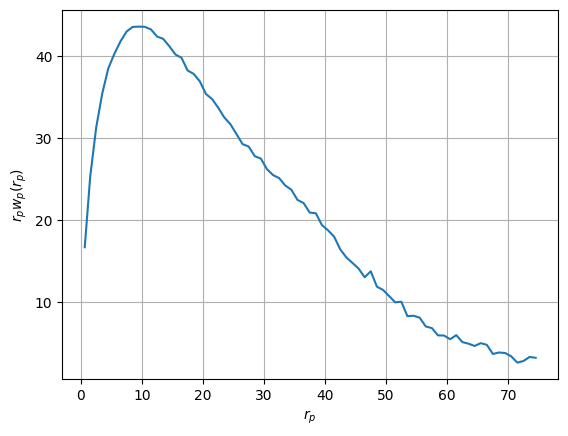

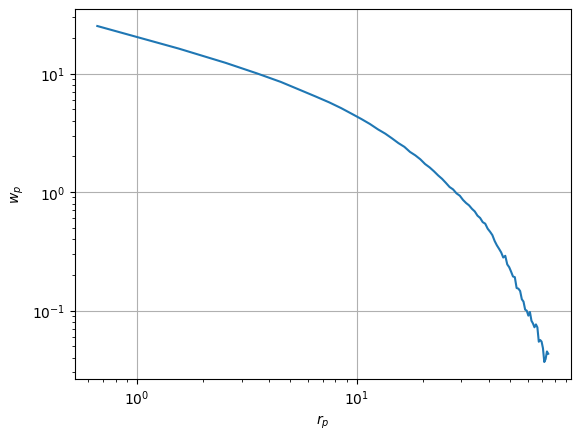

In [32]:
ax = plt.gca()
sep, wp = results_rppi(pimax=None, return_sep=True) # sep is r_p
ax.plot(sep, sep * wp)
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax.grid(True)
plt.show()


ax = plt.gca()
ax.plot(sep, wp)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$w_{p}$')
ax.grid(True)
plt.show()

[-74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5 -66.5 -65.5 -64.5 -63.5
 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5
 -50.5 -49.5 -48.5 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5 -41.5 -40.5 -39.5
 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5 -29.5 -28.5 -27.5
 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5
 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5
  -2.5  -1.5  -0.5   0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5
   9.5  10.5  11.5  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5
  21.5  22.5  23.5  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5  32.5
  33.5  34.5  35.5  36.5  37.5  38.5  39.5  40.5  41.5  42.5  43.5  44.5
  45.5  46.5  47.5  48.5  49.5  50.5  51.5  52.5  53.5  54.5  55.5  56.5
  57.5  58.5  59.5  60.5  61.5  62.5  63.5  64.5  65.5  66.5  67.5  68.5
  69.5  70.5  71.5  72.5  73.5  74.5]
[ 0.66089133  1.55282338  2.53185387  3.52279708  4.51781971  5.51462899
  6.51237499 

/var/folders/4x/vflzd7x97976g882ypz6dy_h0000gq/T/ipykernel_46179/4226804913.py:8: UserWarning: Log scale: values of z <= 0 have been masked
  cp = plt.contourf(RP, PI, xi_rppi[:,75:], levels=20, cmap='viridis', locator=ticker.LogLocator())  # contourf pour la fonction de corrélation 2D
/var/folders/4x/vflzd7x97976g882ypz6dy_h0000gq/T/ipykernel_46179/4226804913.py:20: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(RP, PI, xi_rppi[:,75:], levels=[2, 5, 10, 20, 50], colors='black', linewidths=1, locator=ticker.LogLocator())


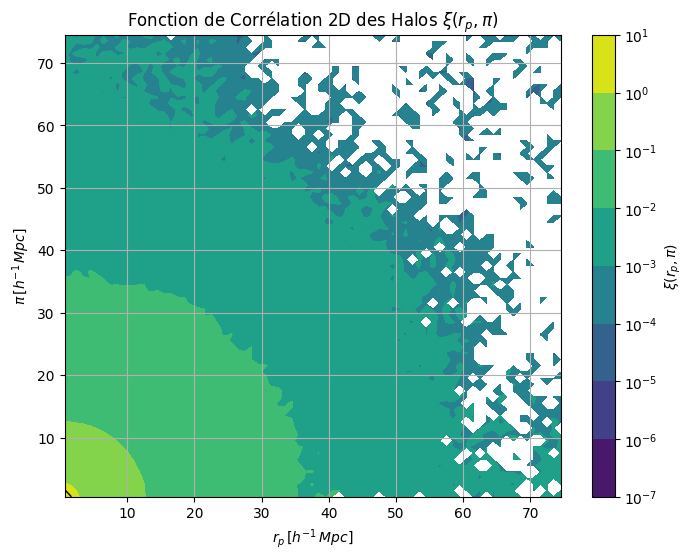

In [33]:
print(pi)
print(sep)

RP, PI = np.meshgrid(sep, pi[75:])

# Création du graphique avec des contours
plt.figure(figsize=(8, 6))
cp = plt.contourf(RP, PI, xi_rppi[:,75:], levels=20, cmap='viridis', locator=ticker.LogLocator())  # contourf pour la fonction de corrélation 2D

# Ajouter une barre de couleur
cbar = plt.colorbar(cp)
cbar.set_label(r'$\xi(r_p, \pi)$')

# Ajouter des labels et un titre
plt.xlabel(r'$r_p \, [h^{-1} \, Mpc]$')
plt.ylabel(r'$\pi \, [h^{-1} \, Mpc]$')
plt.title(r'Fonction de Corrélation 2D des Halos $\xi(r_p, \pi)$')

# Afficher les contours
plt.contour(RP, PI, xi_rppi[:,75:], levels=[2, 5, 10, 20, 50], colors='black', linewidths=1, locator=ticker.LogLocator())

# Affichage du graphique
plt.grid(True)
plt.show()

r_p  sym shape : (150,)
r_p shape : (75,)
pi shape : (150,)
r_p  sym : [-74.50111312 -73.50113385 -72.50115041 -71.50115827 -70.50118104
 -69.501211   -68.50120626 -67.501232   -66.50124151 -65.50125361
 -64.50128239 -63.50131484 -62.50132572 -61.50136884 -60.50136329
 -59.50138897 -58.50141971 -57.50145053 -56.50142732 -55.50149493
 -54.50154009 -53.50156342 -52.50160489 -51.50161561 -50.50165811
 -49.50168615 -48.50170147 -47.50174699 -46.50176497 -45.50181802
 -44.50185227 -43.50188694 -42.50194439 -41.50200805 -40.5020215
 -39.50209392 -38.50214937 -37.50222094 -36.5022893  -35.50230385
 -34.50237764 -33.50250005 -32.5025372  -31.50262389 -30.50269367
 -29.50281668 -28.50293084 -27.50298453 -26.50310322 -25.50319023
 -24.50333477 -23.50346276 -22.50365254 -21.50380898 -20.50399446
 -19.50419006 -18.50443404 -17.50471242 -16.50495099 -15.50524468
 -14.50563451 -13.50603423 -12.5064908  -11.50702052 -10.50770934
  -9.50850418  -8.50950733  -7.51081025  -6.51237499  -5.51462899
  -4.5

/var/folders/4x/vflzd7x97976g882ypz6dy_h0000gq/T/ipykernel_46179/2939027263.py:20: UserWarning: Log scale: values of z <= 0 have been masked
  cp = plt.contourf(RP, PI, xi_rppi_sym, levels=levels, cmap='magma', locator=ticker.LogLocator())
/var/folders/4x/vflzd7x97976g882ypz6dy_h0000gq/T/ipykernel_46179/2939027263.py:33: UserWarning: Log scale: values of z <= 0 have been masked
  contours = plt.contour(RP, PI, xi_rppi_sym, levels=contour_levels, colors='orange', linewidths=1, locator=ticker.LogLocator())


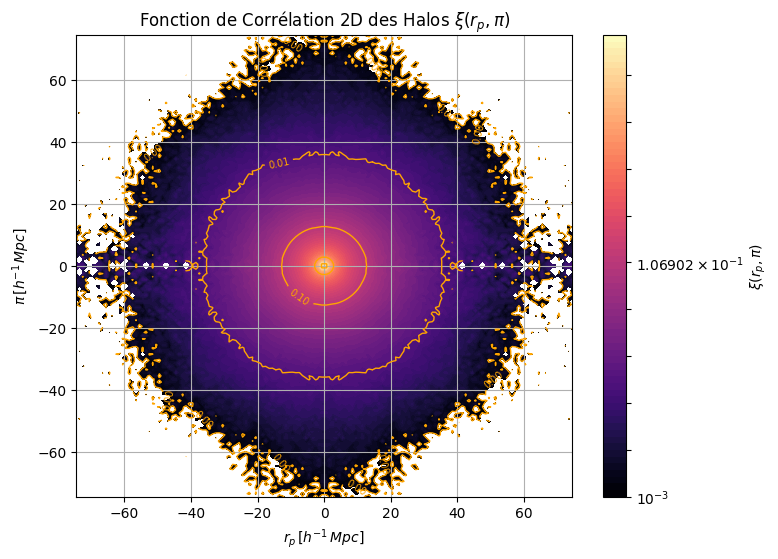

In [34]:
sep_sym = np.concatenate([-sep[::-1], sep])  # Miroir pour r_p
print('r_p  sym shape :', sep_sym.shape)
print('r_p shape :', sep.shape)
print('pi shape :', pi.shape)

print('r_p  sym :', sep_sym)

# Étendre xi_rppi pour correspondre aux valeurs de r_p et pi symétriques
xi_rppi_sym = np.concatenate([xi_rppi[::-1, :], xi_rppi], axis=0)
print('Xi sym shape :', xi_rppi_sym.shape)
print('Xi shape :', xi_rppi.shape)

# Création du meshgrid symétrique
RP, PI = np.meshgrid(sep_sym, pi)

levels = np.logspace(-3, 1, 70)

# Création du graphique avec des contours
plt.figure(figsize=(8, 6))
cp = plt.contourf(RP, PI, xi_rppi_sym, levels=levels, cmap='magma', locator=ticker.LogLocator())

# Ajouter une barre de couleur
cbar = plt.colorbar(cp)
cbar.set_label(r'$\xi(r_p, \pi)$')

# Ajouter des labels et un titre
plt.xlabel(r'$r_p \, [h^{-1} \, Mpc]$')
plt.ylabel(r'$\pi \, [h^{-1} \, Mpc]$')
plt.title(r'Fonction de Corrélation 2D des Halos $\xi(r_p, \pi)$')

# Afficher les contours
contour_levels = [0.001, 0.01, 0.1, 1, 5]
contours = plt.contour(RP, PI, xi_rppi_sym, levels=contour_levels, colors='orange', linewidths=1, locator=ticker.LogLocator())

labels = [r'$\xi = {level}$' for level in contour_levels]
plt.clabel(contours, inline=True, fontsize=7, fmt='%1.2f')

# Affichage du graphique
plt.grid(True)
plt.show()

### With RSD

Shape of velocities: (4836868, 3) 

[270.72039795 374.44009399 235.75689697 ... 519.28411865 630.73419189
  94.70598602] [ 234.61247253  771.42529297  734.37634277 ... -292.92248535  146.41241455
   54.39415741] [147.50946045 310.0227356  247.98565674 ...  23.68218803  10.5315094
 -51.046875  ]
x : [-499.49346924 -499.70275879 -499.52978516 ...  498.99822998  499.96505737
  499.10070801] 
 y : [-499.51290894 -498.85256958 -498.93826294 ...  499.44732666  499.33847046
  499.66027832] 
 z rsd: [-434.2546694  -336.26443549 -304.10514862 ...  208.33156695  294.93300213
  424.86821366] 
 z : [-435.927948   -339.78118896 -306.91818237 ...  208.06292725  294.8135376
  425.44726562]

 delta z : [ 1.6732786   3.51675348  2.81303376 ...  0.26863971  0.11946454
 -0.57905197]


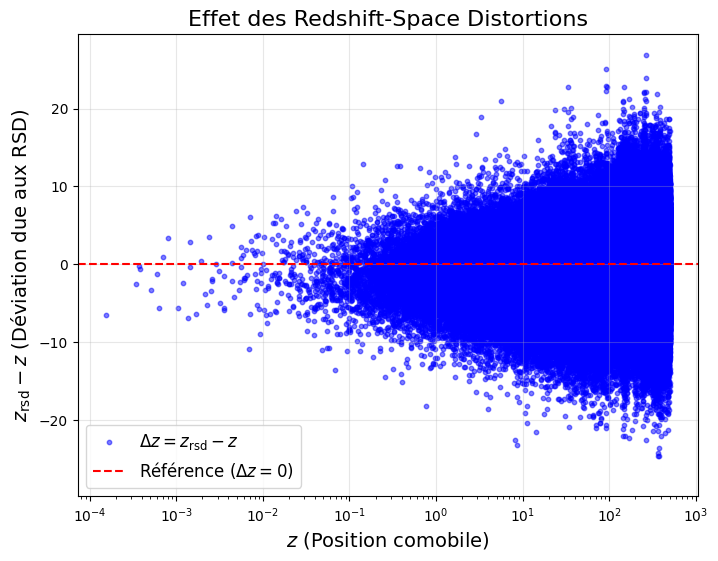

In [114]:
# H0 = 100 # h*km/s/Mpc
z_sim = hcat.header['Redshift']
id = np.array(sampled_halos['id'])
a = hcat.header['ScaleFactor'] # scale factor

# H_z = H0 * np.sqrt(Omega_m*(1+z_sim)**3 + (1 - Omega_m)) # Hubble constant at z
# print('H(z) :', H_z, '\n')
Hz = hcat.header['HubbleNow'] * 100

velocities = np.array(sampled_halos['v_L2com'])
velocities = velocities.astype(np.float64)
print("Shape of velocities:", velocities.shape, '\n')
vx, vy, vz = velocities[:, 0], velocities[:, 1], velocities[:, 2]
print(vx, vy, vz) # km/s

#vz_pec = vz - H_z * z

z_rsd = z + vz / (a * Hz) # Mpc/h

print('x :', x, '\n', 'y :', y, '\n z rsd:', z_rsd, '\n z :', z)
delta_z = z_rsd - z
print('\n delta z :', delta_z)

# Tracé de la figure
# plt.figure(figsize=(8, 6))
# plt.scatter(id, delta_z, alpha=0.5, s=10, c='blue', label=r'$\Delta z = z_{\mathrm{rsd}} - z$')
# plt.axhline(0, color='red', linestyle='--', label=r'Référence ($\Delta z = 0$)')
# plt.xlabel(r"$z$ (Position comobile)", fontsize=14)
# plt.ylabel(r"$z_{\mathrm{rsd}} - z$ (Déviation due aux RSD)", fontsize=14)
# plt.xscale('log')
# plt.title("Effet des Redshift-Space Distortions", fontsize=16)
# plt.grid(alpha=0.3)
# plt.legend(fontsize=12, loc='lower left')
# plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(z, delta_z, alpha=0.5, s=10, c='blue', label=r'$\Delta z = z_{\mathrm{rsd}} - z$')
plt.axhline(0, color='red', linestyle='--', label=r'Référence ($\Delta z = 0$)')
plt.xlabel(r"$z$ (Position comobile)", fontsize=14)
plt.ylabel(r"$z_{\mathrm{rsd}} - z$ (Déviation due aux RSD)", fontsize=14)
plt.xscale('log')
plt.title("Effet des Redshift-Space Distortions", fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=12, loc='lower left')
plt.show()


In [102]:
bins_rp = np.linspace(0, 75, 76)  
bins_pi = np.linspace(-75, 75, 151) 

results_rppi_rsd = TwoPointCorrelationFunction(
    mode='rppi',
    edges=(bins_rp, bins_pi),
    data_positions1=(x, y, z_rsd),  # Modified according to the LOS
    nthreads=16,
    boxsize=boxsize,
    los='z'  
)

In [103]:
pi_rsd = results_rppi_rsd.sepavg(axis=1)
print(pi_rsd)

xi_rppi_rsd = results_rppi_rsd.corr
print(xi_rppi_rsd)

[-74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5 -66.5 -65.5 -64.5 -63.5
 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5
 -50.5 -49.5 -48.5 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5 -41.5 -40.5 -39.5
 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5 -29.5 -28.5 -27.5
 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5
 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5
  -2.5  -1.5  -0.5   0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5
   9.5  10.5  11.5  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5
  21.5  22.5  23.5  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5  32.5
  33.5  34.5  35.5  36.5  37.5  38.5  39.5  40.5  41.5  42.5  43.5  44.5
  45.5  46.5  47.5  48.5  49.5  50.5  51.5  52.5  53.5  54.5  55.5  56.5
  57.5  58.5  59.5  60.5  61.5  62.5  63.5  64.5  65.5  66.5  67.5  68.5
  69.5  70.5  71.5  72.5  73.5  74.5]
[[-1.46210454e-03 -4.14243272e-03  2.25005583e-04 ...  2.25005583e-04
  -4.14243272e-0

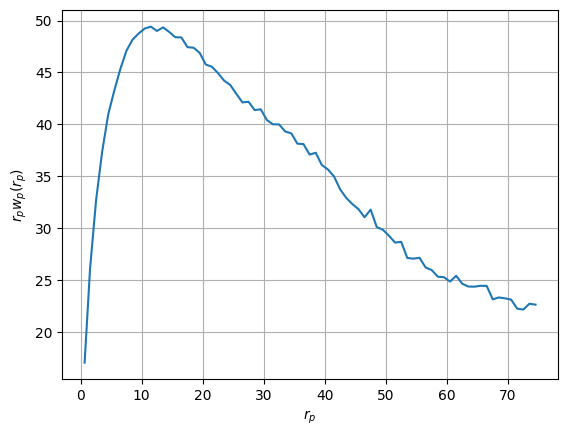

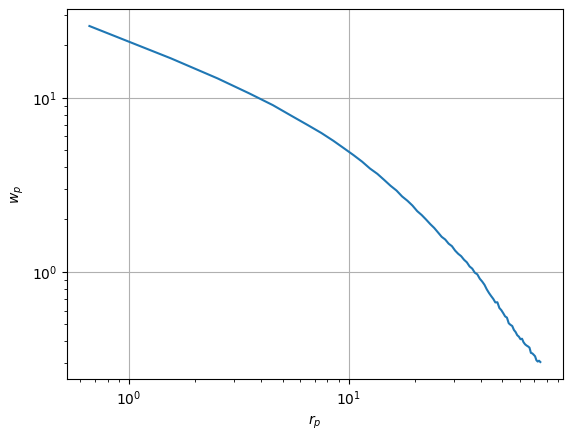

In [104]:
ax = plt.gca()
sep_rsd, wp_rsd = results_rppi_rsd(pimax=None, return_sep=True) # sep is r_p
ax.plot(sep_rsd, sep_rsd * wp_rsd)
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax.grid(True)
plt.show()


ax = plt.gca()
ax.plot(sep_rsd, wp_rsd)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$w_{p}$')
ax.grid(True)
plt.show()

(75, 75) (75, 75) (75, 75)
-0.017435227801024914


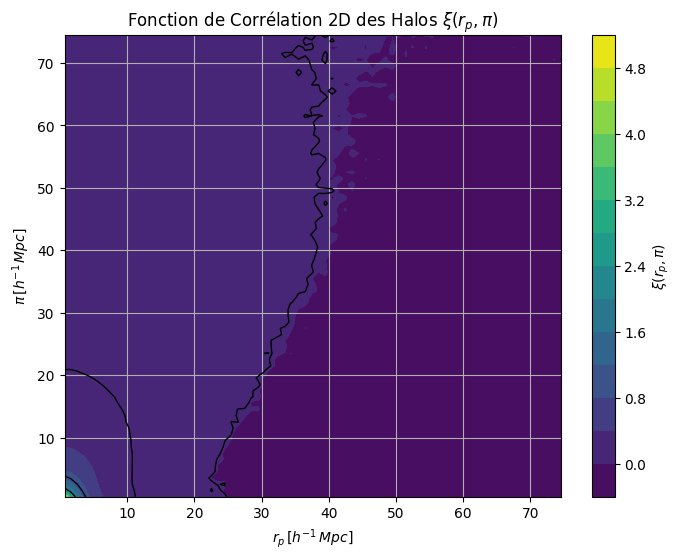

In [105]:
RP_rsd, PI_rsd = np.meshgrid(sep_rsd, pi_rsd[75:])
print(RP_rsd.shape, PI_rsd.shape, xi_rppi_rsd[:,75:].shape)

print(np.min(xi_rppi_rsd))
# Création du graphique avec des contours
plt.figure(figsize=(8, 6))
cp = plt.contourf(RP_rsd, PI_rsd, xi_rppi_rsd[:,75:], levels=15, cmap='viridis')  # contourf pour la fonction de corrélation 2D
# locator=ticker.LogLocator()
# Ajouter une barre de couleur
cbar = plt.colorbar(cp)
cbar.set_label(r'$\xi(r_p, \pi)$')

# Ajouter des labels et un titre
plt.xlabel(r'$r_p \, [h^{-1} \, Mpc]$')
plt.ylabel(r'$\pi \, [h^{-1} \, Mpc]$')
plt.title(r'Fonction de Corrélation 2D des Halos $\xi(r_p, \pi)$')

# Afficher les contours
plt.contour(RP_rsd, PI_rsd, xi_rppi_rsd[:,75:], levels=[-1, -0.1, 0.001, 0.1, 1, 2], colors='black', linewidths=1)

# Affichage du graphique
plt.grid(True)
plt.show()

r_p  sym shape : (150,)
r_p shape : (75,)
pi shape : (150,)
Xi sym shape : (150, 150)
Xi shape : (75, 150)


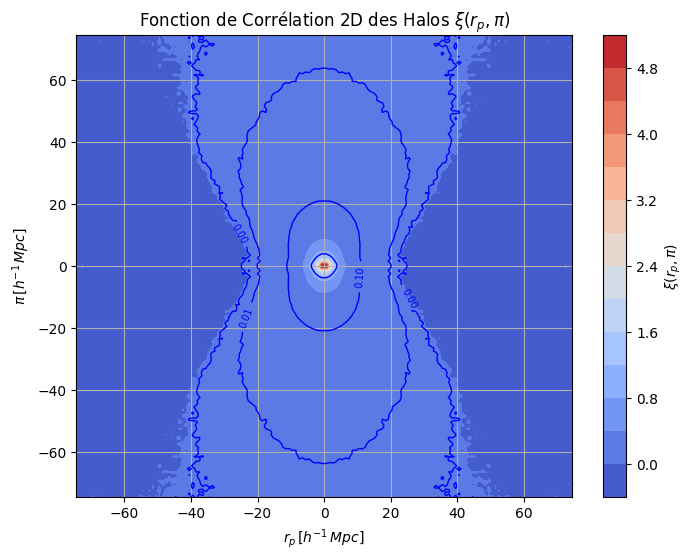

In [110]:
sep_sym_rsd = np.concatenate([-sep_rsd[::-1], sep_rsd])  # Miroir pour r_p
print('r_p  sym shape :', sep_sym_rsd.shape)
print('r_p shape :', sep_rsd.shape)
print('pi shape :', pi_rsd.shape)

# Étendre xi_rppi pour correspondre aux valeurs de r_p et pi symétriques
xi_rppi_sym_rsd = np.concatenate([xi_rppi_rsd[::-1, :], xi_rppi_rsd], axis=0)
print('Xi sym shape :', xi_rppi_sym_rsd.shape)
print('Xi shape :', xi_rppi_rsd.shape)

# Création du meshgrid symétrique
RP_rsd, PI_rsd = np.meshgrid(sep_sym_rsd, pi_rsd)

# levels = np.logspace(-3, 1, 70)

# Création du graphique avec des contours
plt.figure(figsize=(8, 6))
cp = plt.contourf(RP_rsd, PI_rsd, xi_rppi_sym_rsd, levels=15, cmap='coolwarm')

# Ajouter une barre de couleur
cbar = plt.colorbar(cp)
cbar.set_label(r'$\xi(r_p, \pi)$')

# Ajouter des labels et un titre
plt.xlabel(r'$r_p \, [h^{-1} \, Mpc]$')
plt.ylabel(r'$\pi \, [h^{-1} \, Mpc]$')
plt.title(r'Fonction de Corrélation 2D des Halos $\xi(r_p, \pi)$')

# Afficher les contours
contour_levels = [-1, -0.1, 0.001, 0.01, 0.1, 1, 5]
contours = plt.contour(RP_rsd, PI_rsd, xi_rppi_sym_rsd, levels=contour_levels, colors='blue', linewidths=1)

labels = [r'$\xi = {level}$' for level in contour_levels]
plt.clabel(contours, inline=True, fontsize=7, fmt='%1.2f')

# Affichage du graphique
plt.grid(True)
plt.show()

In [106]:
bins_s = np.linspace(0, 100, 51)  # Intervalles des distances en Mpc/h
bins_mu = np.linspace(-1, 1, 201)    # Intervalles des cosinus d'angle

# 2PCF Calculations
results_smu_rsd = TwoPointCorrelationFunction(
    mode='smu',  
    edges=(bins_s, bins_mu),  # Bornes des distances pour les bins
    data_positions1=(x, y, z_rsd),  # Positions des halos
    boxsize=boxsize,  # Taille de la boîte pour corriger les effets de bord
    los='z',
    nthreads=16
)

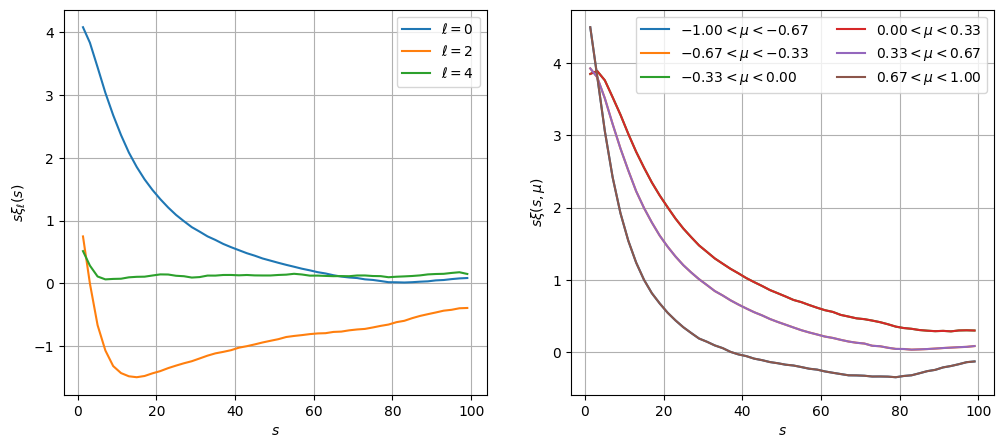

In [54]:
# mid (center of bins) separations can be obtained through
sepmid_rsd = results.sepavg(axis=0, method='mid')

fig, lax = plt.subplots(ncols=2, nrows=1, sharex=False, sharey=False, figsize=(12, 5))

# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
s_rsd, xiell_rsd = results_smu_rsd(ells=ells, return_sep=True)
ax = lax[0]
for ill, ell in enumerate(ells):
    ax.plot(s_rsd, s_rsd * xiell_rsd[ill], label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$s \xi_{\ell}(s)$')

# Let us project to wedges
wedges = (-1., -2./3, -1./3, 0., 1./3, 2./3, 1.)
s_rsd, ximu_rsd = results_smu_rsd(wedges=wedges, return_sep=True)
ax = lax[1]
for iwedge, wedge in enumerate(zip(wedges[:-1], wedges[1:])):
    ax.plot(s_rsd, s_rsd * ximu_rsd[iwedge], label=r'${:.2f} < \mu < {:.2f}$'.format(*wedge))
    
ax.legend(ncol=2)
ax.grid(True)
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$s \xi(s, \mu)$')
plt.show()

In [113]:

# Vérification des doublons
duplicates = []  # Liste pour stocker les indices des wedges identiques
for i, wedge1 in enumerate(zip(wedges[:-1], wedges[1:])):
    for j, wedge2 in enumerate(zip(wedges[:-1], wedges[1:])):
        if i < j:  # Éviter les comparaisons inutiles (symétriques ou mêmes indices)
            if np.allclose(ximu_rsd[i], ximu_rsd[j]):  # Vérifie si les valeurs sont identiques
                duplicates.append((i, j))
                print(f"Les wedges {i} et {j} ont les mêmes valeurs")


Les wedges 0 et 5 ont les mêmes valeurs
Les wedges 1 et 4 ont les mêmes valeurs
Les wedges 2 et 3 ont les mêmes valeurs


r_p range: 0.6609221608495239 74.50111002718363
pi range: -74.5 74.5
xi range: -0.017435227801024914 4.865741754500202


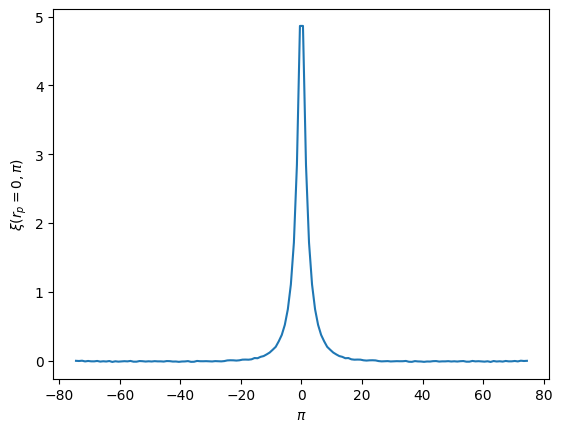

In [108]:
print("r_p range:", sep_rsd.min(), sep_rsd.max())
print("pi range:", pi_rsd.min(), pi_rsd.max())
print("xi range:", xi_rppi_rsd.min(), xi_rppi_rsd.max())

plt.plot(pi_rsd, xi_rppi_rsd[0, :], label='Slice at rp=0')
plt.xlabel(r'$\pi$')
plt.ylabel(r'$\xi(r_p=0, \pi)$')
plt.show()

# Test

In [41]:
# red = sampled_halos.header[' L1OutputRedshifts']
red = hcat.header['L1OutputRedshifts']
ini_red = hcat.header['InitialRedshift']
fin_red = hcat.header['FinalRedshift']
timeslice_red = hcat.header['TimeSliceRedshifts']
timeslice_sub_red = hcat.header['TimeSliceRedshifts_Subsample']

print('List of z :', red, '\n', 'Initial redshift :', ini_red, '\n', 'Final redshift : ', fin_red, '\n', 'Redshift :', z_sim)
print('\n', 'Time Slice Redshift :', timeslice_red, '\n', 'Time Slice Subsample Redshift :', timeslice_sub_red)

List of z : [8.0, 5.0, 3.0, 2.75, 2.5, 2.25, 2.0, 1.85, 1.7, 1.625, 1.55, 1.475, 1.4, 1.325, 1.25, 1.175, 1.1, 1.025, 0.95, 0.875, 0.8, 0.725, 0.65, 0.575, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1] 
 Initial redshift : 99.0 
 Final redshift :  0.1 
 Redshift : 0.5

 Time Slice Redshift : [3.0, 2.5, 2.0, 1.7, 1.4, 1.1, 0.8, 0.5, 0.4, 0.3, 0.2, 0.1] 
 Time Slice Subsample Redshift : [3.0, 2.5, 2.0, 1.7, 1.4, 1.1, 0.8, 0.5, 0.4, 0.3, 0.2, 0.1]


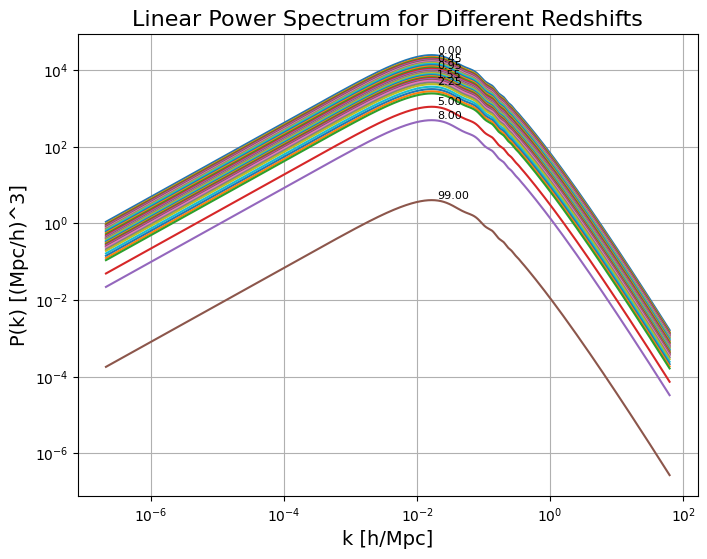

In [42]:
meta = abacusnbody.metadata.get_meta('AbacusSummit_base_c000_ph000')

Dz = meta['GrowthTable']
zpk = meta['ZD_Pk_file_redshift']  # 1.0
input_pk = meta['CLASS_power_spectrum']

# Retrieve redshift information
z_values = np.array(list(Dz.keys()))

# Turn input_pk into a numpy array
k_values = input_pk['k (h/Mpc)']  
pk_values = input_pk['P (Mpc/h)^3']  

k_values_array = np.array(k_values)
pk_values_array = np.array(pk_values)

# Compute Linear Power Spectra

plt.figure(figsize=(8, 6))

annotations = []
# P(k) for each z target
for ztarget in z_values:
    linear_pk = pk_values_array * (Dz[ztarget] / Dz[zpk])**2
    plt.plot(k_values_array, linear_pk, label=f"z = {ztarget}")

    # Annotation in the middle of the plot
    # idx = len(k_values_array) // 2  # Approximatively the middle
    # plt.text(k_values_array[idx], linear_pk[idx], f"z={ztarget:.2f}", 
    #          fontsize=8, color="black", ha='left', va='bottom')

    # Legend
    idx = len(k_values_array) // 2
    x_pos = k_values_array[idx]
    y_pos = linear_pk[idx]
    
    min_distance = 0.2  # Minimum distance to avoid overlaping
    can_place = all(
        np.sqrt((np.log10(x_pos) - np.log10(ax))**2 + (np.log10(y_pos) - np.log10(ay))**2) > min_distance
        for ax, ay in annotations
    )
    
    if can_place:
        plt.text(x_pos, y_pos, f"{ztarget:.2f}", fontsize=8, color="black", ha='left', va='bottom')
        annotations.append((x_pos, y_pos))  # Save the position 

plt.xlabel("k [h/Mpc]", fontsize=14)
plt.ylabel("P(k) [(Mpc/h)^3]", fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.title("Linear Power Spectrum for Different Redshifts", fontsize=16)
plt.grid(True)

plt.show()

Dz : {0.0: 77.86540103136878, 0.1: 73.85417664462433, 0.15: 71.91841655224486, 0.2: 70.03440897542454, 0.25: 68.20479935934229, 0.3: 66.43137543471862, 0.35: 64.71518072694363, 0.4: 63.056623675905335, 0.45: 61.45557983124955, 0.5: 59.91148545808563, 0.575: 57.700035377292544, 0.65: 55.61037003373727, 0.725: 53.63731260603211, 0.8: 51.77510097391521, 0.875: 50.017673300505145, 0.95: 48.3588803545228, 1.0: 47.30480505646196, 1.025: 46.79263857159667, 1.1: 45.31303645157096, 1.175: 43.914405052628226, 1.25: 42.591361438207, 1.325: 41.33883216236731, 1.4: 40.15206233755742, 1.475: 39.02661454292454, 1.55: 37.958360791483955, 1.625: 36.94346995268534, 1.7: 35.978392389074756, 1.85: 34.18478411939205, 2.0: 32.554116849779646, 2.25: 30.145402992847387, 2.5: 28.05925297301799, 2.75: 26.2370527797529, 3.0: 24.633012682833417, 5.0: 16.510239757235368, 8.0: 11.032993025229876, 99.0: 1.0} 

linear pk : [1.79062750e-04 6.98377550e-04 1.20234738e-03 ... 9.42306270e-07
 5.03780610e-07 2.68344540e-07

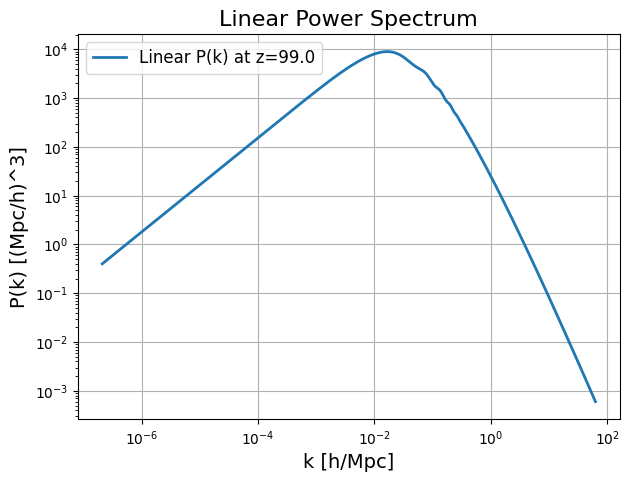

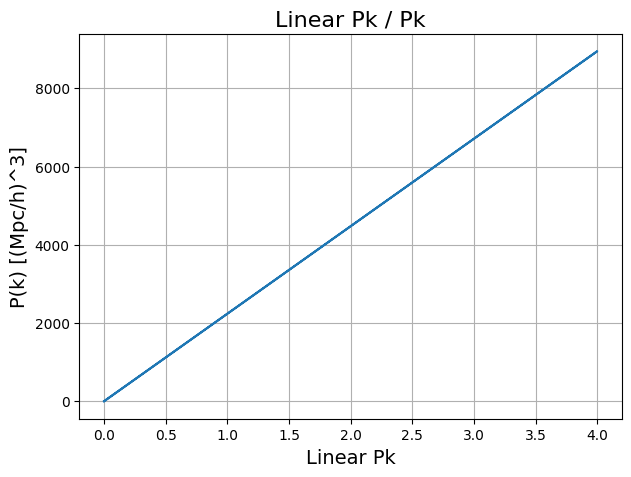

In [43]:
# Display
print('Dz :', Dz, '\n')
print('linear pk :',linear_pk, '\n')
print('pk_values_array :',pk_values_array, '\n')
print('Dz[ztarget] :', Dz[ztarget])
print('Dz[zpk] :', Dz[zpk])

plt.figure(figsize=(7, 5))
plt.plot(k_values_array, pk_values_array, label=f"Linear P(k) at z={ztarget}", lw=2)
plt.xlabel("k [h/Mpc]", fontsize=14)
plt.ylabel("P(k) [(Mpc/h)^3]", fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.title("Linear Power Spectrum", fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(linear_pk, pk_values_array)
plt.xlabel("Linear Pk", fontsize=14)
plt.ylabel("P(k) [(Mpc/h)^3]", fontsize=14)
plt.title("Linear Pk / Pk", fontsize=16)
plt.grid()
plt.show()

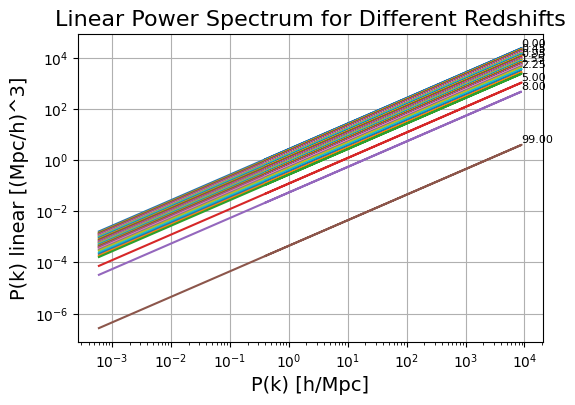

In [44]:
plt.figure(figsize=(6, 4))

annotations = []
# P(k) for each z target
for ztarget in z_values:
    linear_pk = pk_values_array * (Dz[ztarget] / Dz[zpk])**2
    plt.plot(pk_values_array, linear_pk, label=f"z = {ztarget}")

    # Annotation in the middle of the plot
    # idx = len(k_values_array) // 2  # Approximatively the middle
    # plt.text(k_values_array[idx], linear_pk[idx], f"z={ztarget:.2f}", 
    #          fontsize=8, color="black", ha='left', va='bottom')

    # Legend
    idx = len(pk_values_array) // 2
    x_pos = pk_values_array[idx]
    y_pos = linear_pk[idx]
    
    min_distance = 0.2  # Minimum distance to avoid overlaping
    can_place = all(
        np.sqrt((np.log10(x_pos) - np.log10(ax))**2 + (np.log10(y_pos) - np.log10(ay))**2) > min_distance
        for ax, ay in annotations
    )
    
    if can_place:
        plt.text(x_pos, y_pos, f"{ztarget:.2f}", fontsize=8, color="black", ha='left', va='bottom')
        annotations.append((x_pos, y_pos))  # Save the position 

plt.xlabel("P(k) [h/Mpc]", fontsize=14)
plt.ylabel("P(k) linear [(Mpc/h)^3]", fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.title("Linear Power Spectrum for Different Redshifts", fontsize=16)
plt.grid(True)

plt.show()